# HCC1806 Data Preprocessing

## Introduction
The structure of the file is the following:
1. EDA (Exploratory Data Analysis)
    * Metadata Files
    * Sequencing Data (HCC1806)
        * Description
        * Duplicates    
            * Cells correlation 
        * Sparsity and NANs
        * Labeling
        * Outliers
            * Boxplot
            * IQR
            * After Normalization  
        * Distribution
            * Histogram
            * (Density Plot)
            * Test for Normality
            * Test for other distributions
        * Correlation
            * More on cells correlation
            * Genes correlation
        * Transformations
        * Normalization

2. Dimensionality Reduction 
## Materials and Methods

## Libraries

In [1]:
# Check for libraries that are needed
!pip install pandas
!pip install numpy==1.19.5
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy.stats
!pip install scanpy


  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1021 lines of output]
      setup.py:67: RuntimeWarning: NumPy 1.19.5 may not yet support Python 3.11.
        warnings.warn(
      Running from numpy source directory.
      Cythonizing sources
      numpy/random/_bounded_integers.pxd.in has not changed
      numpy/random/_philox.pyx has not changed
      numpy/random/_bounded_integers.pyx.in has not changed
      numpy/random/_sfc64.pyx has not changed
      numpy/random/_mt19937.pyx has not changed
      numpy/random/bit_generator.pyx has not changed
      Processing numpy/random/_bounded_integers.pyx
      numpy/random/mtrand.pyx has not changed
      numpy/random/_generator.pyx has not changed
      numpy/random/_pcg64.pyx 

In [243]:
# install additional packages
!pip install -q scanpy
!pip install -q scikit-misc
!pip install -q pyvis
!pip install -q leidenalg

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
import torch as th
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kstest
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import nbinom
from scipy.stats import gamma
from scipy.stats import chi2_contingency
import scipy.stats as stats
import random
from scipy.stats import mannwhitneyu
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import plotly

------------------------------------------------------------------------

------------------------------------------------------------------------

## EDA (Exploratory Data Analysis)
Now we start by loading the 4 dataset.
Each of them is from a single experiment, and each experiment is different because of the sequencing technique for the cells' RNA, and of the cells' environment.

### Metadata files
We start with the metadata files, one for each experiment. They are TSV files

In [4]:
df_metaM_path = '../ai_lab/SmartSeq/MCF7_SmartS_MetaData.tsv'
df_metaM = pd.read_csv(df_metaM_path, delimiter='\t')
print("Dataframe dimensions:", df_metaM.shape)
print("Dataframe columns:", df_metaM.columns)

Dataframe dimensions: (383, 9)
Dataframe columns: Index(['Filename', 'Cell Line', 'Lane', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')


In [5]:
#we drop the first column 'Filename' as it is not needed

df_metaM = df_metaM.drop(columns=['Filename'])
df_metaM.head()

,Cell Line,Lane,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,MCF7,output.STAR.1,A10,Hypo,72,S28,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,MCF7,output.STAR.1,A11,Hypo,72,S29,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,MCF7,output.STAR.1,A12,Hypo,72,S30,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,MCF7,output.STAR.1,A1,Norm,72,S1,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,MCF7,output.STAR.1,A2,Norm,72,S2,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


In [6]:
df_metaH_path = '../ai_lab/SmartSeq/HCC1806_SmartS_MetaData.tsv'
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')
print("Dataframe dimensions:", df_metaH.shape)
print("Dataframe columns:", df_metaH.columns)

Dataframe dimensions: (243, 9)
Dataframe columns: Index(['Filename', 'Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')


In [7]:
df_metaH.head()

,Filename,Cell Line,PCR Plate,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...,HCC1806,1,A10,Normo,24,S123,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....,HCC1806,1,A12,Normo,24,S26,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...,HCC1806,1,A1,Hypo,24,S97,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...,HCC1806,1,A2,Hypo,24,S104,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...,HCC1806,1,A3,Hypo,24,S4,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


## What is the dataset made of?

For every row, we have a single observation from an experiment, and of course in the columns we have the collected data of the experiment. In order:
#### 1.  Cell Line 
  Content

#### 2. Lane
  Content

#### 3. Pos
  Content

#### 4. Condition
  Content

#### 5. Hours
  Content

#### 6. Cell Name
  Content

#### 7. Preprocessing Tag
  Content
  
#### 8. ProcessingComments
  Content


Condition
Hypo     126
Normo    117
Name: count, dtype: int64


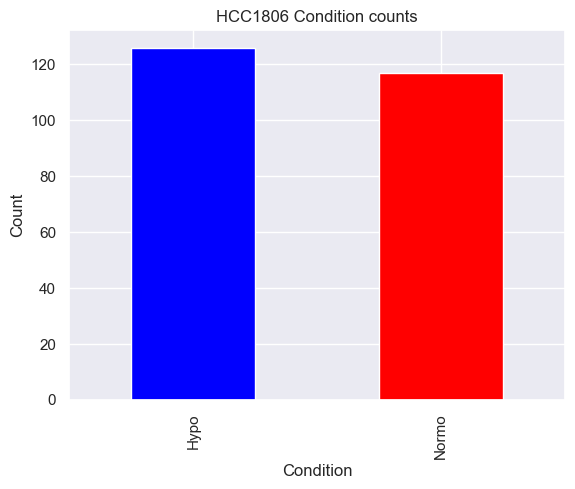

In [13]:
# before starting the analysis of seqdata we check the counts for Norm or Hypo
# in the column 'Condition' for both the datasets count the number of Norm and Hypo
counts = df_metaH['Condition'].value_counts()
# Histogram of the counts
print(counts)
# Plot the histogram with two columns for each condition
counts.plot(kind='bar', color=['blue', 'red'])
plt.title('HCC1806 Condition counts')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()


They have similar count so we can proceed with the analysis.

## Sequencing data

Now we go to sequencing data, and we notice that they are space-delimited.
Here we just create the path and the dataset on Python.
 


In [3]:
#We just create the path and the dataset on Python
df_seq_pathHFilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Data.txt'

df_seq_pathHFiltNorm = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathHUnfilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt'

df_seq_pathMFilt = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Data.txt'

df_seq_pathMFiltNorm = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathMUnfilt = '../ai_lab/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt'

df_seq_HFilt = pd.read_csv(df_seq_pathHFilt, delimiter=' ')

df_seq_HFiltNorm = pd.read_csv(df_seq_pathHFiltNorm, delimiter=' ')

df_seq_HUnfilt = pd.read_csv(df_seq_pathHUnfilt, delimiter=' ')

df_seq_MFilt = pd.read_csv(df_seq_pathMFilt, delimiter=' ')

df_seq_MFiltNorm = pd.read_csv(df_seq_pathMFiltNorm, delimiter=' ')

df_seq_MUnfilt = pd.read_csv(df_seq_pathMUnfilt, delimiter=' ')

There are six dataset, and we can understand what they actually are based on their name, for the EDA part we focus on the Unfiltered datased but then we will use Filtered and Normalised one for supervised/uns ML.

#### 1. SmartSeq\HCC1806_SmartS_Unfiltered_Data.txt
  The cell line is HCC1806, the technology is SmartS, and this dataset contains the Unfiltered data

#### 2. SmartSeq\MCF7_SmartS_Unfiltered_Data.txt
  The cell line is MCF7, the technology is SmartS, and this dataset contains the Unfiltered data



We analyze one dataset at a time.

#### 1. SmartSeq\HCC1806_SmartS_Unfiltered_Data.txt

In [15]:
# Exploring the dataframe for the unfiltered data
print("Dataframe dimension:", df_seq_HUnfilt.shape)
print("First Column:", df_seq_HUnfilt.iloc[:,0])
print("Columns list:", list(df_seq_HUnfilt.columns))
# Hence we see features on the rows and therefore we need to transpose the data matrix

Dataframe dimension: (23396, 243)
First Column: WASH7P         0
CICP27         0
DDX11L17       0
WASH9P         0
OR4F29         2
            ... 
MT-TE         22
MT-CYB      4208
MT-TT         26
MT-TP         66
MAFIP          0
Name: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam, Length: 23396, dtype: int64
Columns list: ['output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam', 'output.STAR.PCRPl

In [16]:
# Check for the types of data in the dataframe
print("Data types in the dataframe:", df_seq_HUnfilt.dtypes)
# Check for features
gene_symbols = df_seq_HUnfilt.index
print("Gene symbols in the dataframe:",gene_symbols)

Data types in the dataframe: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       int64
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        int64
                                                                        ...  
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     int64
Length: 243, dtype: object
Gene symbols in the dataframe: Index(['WASH7P', 'CICP27', 'DDX11L17', 'WASH9P', 'OR4F2

In [17]:
# Take the transpose of the dataframe
print("Dataframe dimension before transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt = df_seq_HUnfilt.T
print("Dataframe dimension after transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt.head(5)


Dataframe dimension before transpose: (23396, 243)
Dataframe dimension after transpose: (243, 23396)


,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,17,5,15,3852,900,22,4208,26,66,0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,49,29,36,7457,1439,43,6491,62,71,4
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,0,93,12,0,25,0,1,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,43,17,8,1479,234,0,4819,11,3,7
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,0,3,303,33,0,310,4,9,0


In [18]:
# Now we look at evetual missing values in the dataframe
print("Missing values in the dataframe by columns:", df_seq_HUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_HUnfilt.isna().sum().sum())

Missing values in the dataframe by columns: WASH7P      0
CICP27      0
DDX11L17    0
WASH9P      0
OR4F29      0
           ..
MT-TE       0
MT-CYB      0
MT-TT       0
MT-TP       0
MAFIP       0
Length: 23396, dtype: int64
Missing values in the whole dataframe: 0


In [19]:
df_seq_HUnfilt.describe()

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,0.045267,0.119342,0.469136,0.255144,0.127572,117.930041,28.427984,904.308642,1.403292,0.378601,...,10.358025,5.930041,13.493827,2290.213992,386.901235,18.246914,2163.588477,20.613169,46.444444,3.897119
std,0.318195,0.594531,1.455282,0.818639,0.440910,103.038022,26.062662,654.520308,1.735003,0.747361,...,10.910199,7.040559,11.803967,1726.423259,309.276105,54.076514,1730.393947,22.224590,47.684223,4.736193
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,46.500000,8.000000,390.500000,0.000000,0.000000,...,2.000000,1.000000,4.000000,918.000000,138.500000,4.000000,947.500000,5.000000,14.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000,22.000000,790.000000,1.000000,0.000000,...,7.000000,4.000000,10.000000,1848.000000,320.000000,11.000000,1774.000000,14.000000,38.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,42.000000,1208.000000,2.000000,1.000000,...,14.000000,7.500000,20.000000,3172.000000,528.000000,20.000000,2927.000000,30.500000,64.500000,6.000000
max,3.000000,5.000000,12.000000,6.000000,4.000000,694.000000,120.000000,3569.000000,12.000000,4.000000,...,52.000000,43.000000,57.000000,8972.000000,1439.000000,804.000000,11383.000000,154.000000,409.000000,24.000000


In [12]:
# Now we want to add the target column (i.e. the class) to the dataframe, we get the condition from metadata
print(df_metaH.columns)
df_metaH.set_index('Filename', inplace=True)
# Merge the two dataframes with key 'Filename'
merged_df = pd.merge(df_seq_HUnfilt, df_metaH['Condition'], left_index=True, right_index=True)
print(merged_df.columns)

Index(['Filename', 'Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')
Index(['output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam',
       'output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam',
       ...
       'output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedBy

In [21]:
# Now transform the categorical variable 'Condition' to numerical
dummy_variables = pd.get_dummies(merged_df['Condition'], prefix='category').astype('int')
merged = pd.concat([merged_df, dummy_variables], axis=1)
print(merged.head())
merged.drop(columns=['category_Hypo', 'Condition'], inplace=True)
merged.rename(columns={'category_Normo': 'Target'}, inplace=True)
# Note that 1 = Hypo, 0 = Norm

                                                    WASH7P  CICP27  DDX11L17  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....       0       0         0   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...       0       0         0   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...       0       0         0   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...       0       0         0   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...       0       0         0   

                                                    WASH9P  OR4F29  MTND1P23  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....       0       2       250   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...       0       0       424   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...       0       0        11   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...       0       0        63   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...       0       0        27   

                                      

In [22]:
merged.head()

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,Target
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,5,15,3852,900,22,4208,26,66,0,1
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,29,36,7457,1439,43,6491,62,71,4,1
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,93,12,0,25,0,1,0,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,17,8,1479,234,0,4819,11,3,7,0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,3,303,33,0,310,4,9,0,0


We now look for:
1. Duplicates
2. Sparsity
3. NaNs
4. Outliers
5. Distributions
6. Correlation
7. Normalization

In [23]:
# Check for duplicates
print("Number of duplicates in the dataframe:", merged.duplicated().sum())
# we will now check for duplicates in a broader sense, by checking for observations with high correlation
# we start by computing the correlation matrix of the observations
merged_t = merged.T
correlation_matrix_transpose = merged_t.corr()
correlation_matrix_transpose

Number of duplicates in the dataframe: 0


,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,1.000000,0.885408,0.708625,0.653408,0.824436,0.609023,0.792510,0.783928,0.840470,0.822341,...,0.847737,0.814893,0.826188,0.761642,0.810922,0.830722,0.768022,0.823640,0.793325,0.908514
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0.885408,1.000000,0.787491,0.712392,0.763074,0.503226,0.842720,0.831966,0.700703,0.660058,...,0.817527,0.849628,0.809915,0.851634,0.901613,0.890650,0.833961,0.822712,0.825061,0.909377
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0.708625,0.787491,1.000000,0.799102,0.796600,0.467038,0.748183,0.914489,0.694367,0.573159,...,0.709837,0.789878,0.816019,0.825990,0.878757,0.844358,0.860893,0.819794,0.834061,0.846250
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0.653408,0.712392,0.799102,1.000000,0.672236,0.383586,0.737598,0.758525,0.568934,0.456410,...,0.634569,0.772128,0.756812,0.770083,0.771772,0.815416,0.789164,0.808111,0.818142,0.716827
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0.824436,0.763074,0.796600,0.672236,1.000000,0.736620,0.768692,0.894483,0.880643,0.803900,...,0.826388,0.838407,0.904886,0.807674,0.768156,0.773938,0.732942,0.884343,0.806458,0.817619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0.830722,0.890650,0.844358,0.815416,0.773938,0.429062,0.807162,0.830548,0.681540,0.582953,...,0.788609,0.840471,0.807691,0.847171,0.938814,1.000000,0.910589,0.863634,0.922527,0.903195
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0.768022,0.833961,0.860893,0.789164,0.732942,0.387553,0.704101,0.783934,0.659239,0.516405,...,0.718840,0.750955,0.737012,0.772671,0.900419,0.910589,1.000000,0.830675,0.889423,0.850197
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0.823640,0.822712,0.819794,0.808111,0.884343,0.591267,0.830219,0.861926,0.762216,0.664981,...,0.786382,0.900226,0.906667,0.890142,0.832797,0.863634,0.830675,1.000000,0.900850,0.811386
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,0.793325,0.825061,0.834061,0.818142,0.806458,0.481299,0.771377,0.820861,0.706637,0.599394,...,0.771993,0.840093,0.837265,0.818937,0.888200,0.922527,0.889423,0.900850,1.000000,0.843181


In [24]:
# now we will check for observations with high correlation and drop them
columns_to_keep = []

def add_representative(corr_matrix, col, threshold=0.95):
    corr = corr_matrix[col].drop(col)
    max_corr_id = corr.idxmax()
    max_corr = corr[max_corr_id]
    if max_corr < threshold:
        columns_to_keep.append(col)
        return None
    else:
        if (col not in columns_to_keep) and (max_corr_id not in columns_to_keep):
            columns_to_keep.append(col)
            print('choosing %s as representative for %s with correlation %s' % (col, max_corr_id, max_corr))
            return None
        


for col in merged_t:
    add_representative(correlation_matrix_transpose, col, 0.95)

dropped_cols = [col for col in merged_t if col not in columns_to_keep]

merged_uncorr_obs = merged_t[columns_to_keep].T
print('dropped %s observations' % str(len(dropped_cols)))
merged_uncorr_obs

choosing output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam as representative for output.STAR.PCRPlate1G7_Normoxia_S118_Aligned.sortedByCoord.out.bam with correlation 0.9535484904189891
choosing output.STAR.PCRPlate1B12_Normoxia_S27_Aligned.sortedByCoord.out.bam as representative for output.STAR.PCRPlate1E7_Normoxia_S116_Aligned.sortedByCoord.out.bam with correlation 0.9653734408814555
choosing output.STAR.PCRPlate1B6_Hypoxia_S12_Aligned.sortedByCoord.out.bam as representative for output.STAR.PCRPlate2F6_Hypoxia_S145_Aligned.sortedByCoord.out.bam with correlation 0.9554648521898538
choosing output.STAR.PCRPlate1C10_Normoxia_S124_Aligned.sortedByCoord.out.bam as representative for output.STAR.PCRPlate3B9_Normoxia_S84_Aligned.sortedByCoord.out.bam with correlation 0.9520221458797854
choosing output.STAR.PCRPlate1C1_Hypoxia_S99_Aligned.sortedByCoord.out.bam as representative for output.STAR.PCRPlate4C1_Hypoxia_S222_Aligned.sortedByCoord.out.bam with correlation 0.95042695

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,Target
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,5,15,3852,900,22,4208,26,66,0,1
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,29,36,7457,1439,43,6491,62,71,4,1
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,93,12,0,25,0,1,0,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,17,8,1479,234,0,4819,11,3,7,0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,3,303,33,0,310,4,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,4,386,1,0,...,5,5,746,119,4,999,8,22,1,0
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0,0,0,1,0,146,47,961,1,0,...,17,11,2926,423,26,3719,42,48,3,1
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0,0,0,0,0,37,6,372,0,0,...,1,3,688,114,1,984,1,18,0,1
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0,0,0,1,0,83,30,1128,4,0,...,6,23,2999,486,4,2256,15,36,2,0


In [25]:
# Check for sparsity
total_elements = merged.shape[0] * merged.shape[1]
print("Total number of elements in the DataFrame:", total_elements)
missing_values = (merged == 0).sum().sum()
print("Total number of missing values in the DataFrame:", missing_values)
# Calculate the sparsity as the percentage of missing values
sparsity = (missing_values / total_elements) * 100
print("Sparsity of the DataFrame: {:.2f}%".format(sparsity))

Total number of elements in the DataFrame: 5685471
Total number of missing values in the DataFrame: 3175077
Sparsity of the DataFrame: 55.85%


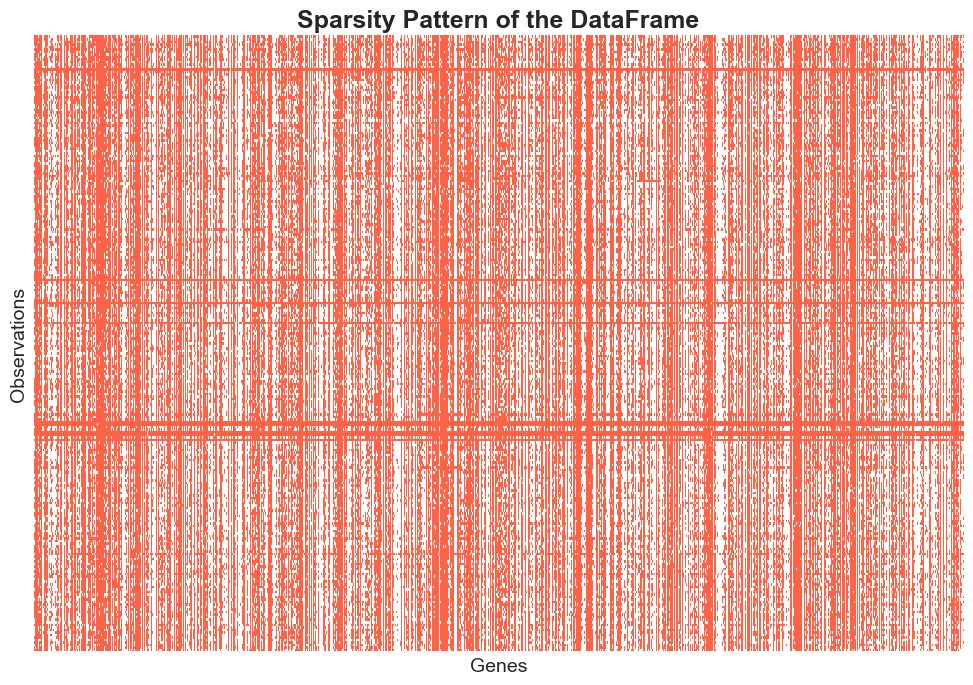

In [26]:
# Visualization of sparsity
# Assuming merged is your DataFrame

# Create a binary DataFrame indicating missing values (1 for missing, 0 for not missing)
missing_mask = merged == 0

# Set up a custom color palette
colors = ["#FFFFFF", "#FF6347"]  # White for non-missing, red for missing

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_mask, cmap=sns.color_palette(colors), cbar=False, xticklabels=False, yticklabels=False)

# Add title and labels with custom font size and style
plt.title('Sparsity Pattern of the DataFrame', fontsize=18, fontweight='bold')
plt.xlabel('Genes', fontsize=14)
plt.ylabel('Observations', fontsize=14)



# Remove the spines (borders) of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


DA AGGIUNGERE PACO

In [21]:
# Check for NaN values
print("Number of NaN values in the DataFrame:", merged.isna().sum().sum())

Number of NaN values in the DataFrame: 0


for outliers: first we do boxplot : it doesnt work because otherwise you remove too many rows
then inter-quantile range prox rule: it works(?)
z score we don t do it because not norm distr
edo's one with normalization


Outliers for dataset with rows as cells and columns as genes

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

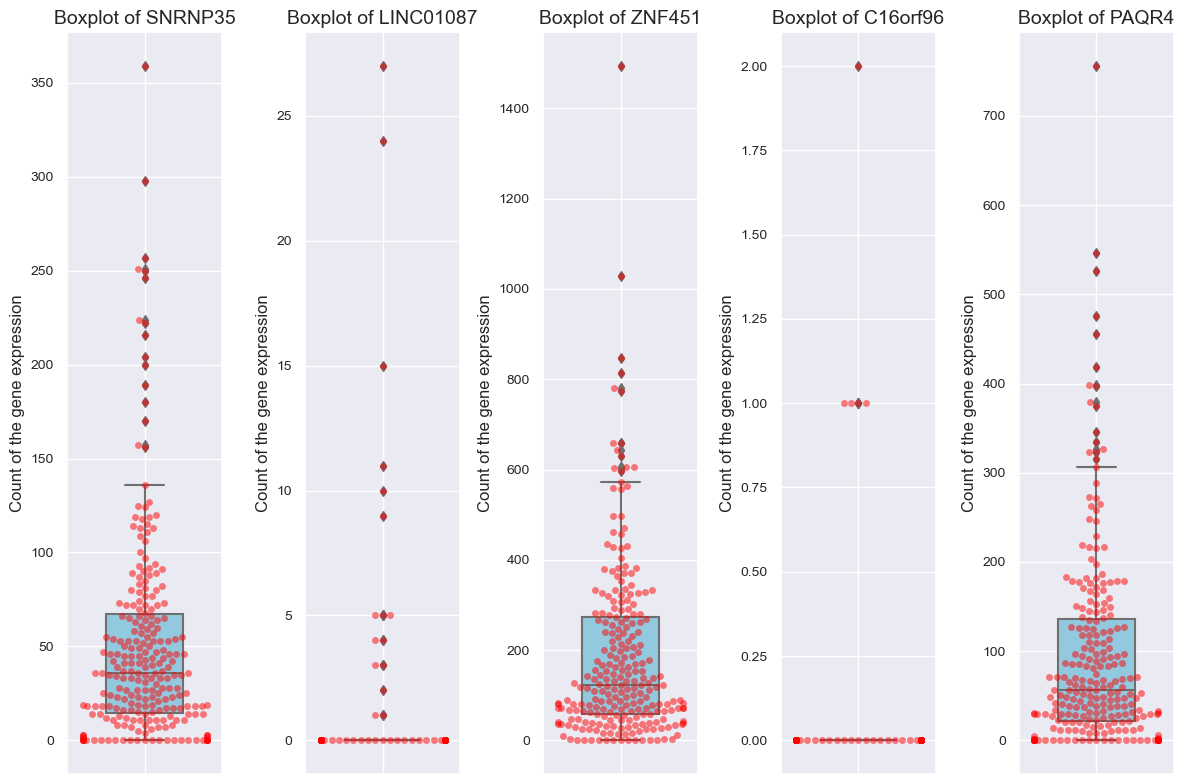

In [22]:
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 5

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)


plt.figure(figsize=(12, 8))  
for i, column in enumerate(random_columns):
    plt.subplot(1, len(random_columns), i+1)
    
    # Customizing boxplot appearance
    sns.boxplot(y=merged[column], color='skyblue', width=0.5)
    
    # Overlaying swarmplot for better visualization of individual data points
    sns.swarmplot(y=merged[column], color='red', alpha=0.5)
    
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel('Count of the gene expression', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)


plt.tight_layout()
plt.show()

In [23]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
outliers = (merged < (Q1 - 1.5 * IQR)) | (merged > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

Number of outliers in the DataFrame: WASH7P       6
CICP27      13
DDX11L17    43
WASH9P      34
OR4F29      24
            ..
MT-CYB       9
MT-TT        5
MT-TP        9
MAFIP        9
Target       0
Length: 23397, dtype: int64
6.87%


Another approach: normalize each column independently and find the outliers of the flattened array

In [27]:
# now we normalize each column independently
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_df_normalized = merged[merged.columns[:-1]].copy()
features_df_normalized[features_df_normalized.columns] = scaler.fit_transform(features_df_normalized[features_df_normalized.columns])
features_df_normalized.describe()

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
count,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,...,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02
mean,-1.462022e-17,2.558539e-17,4.020561e-17,-2.558539e-17,-5.848088e-17,4.386066e-17,-4.797260e-17,-1.462022e-17,5.482583e-17,-4.523131e-17,...,-4.386066e-17,-3.655055e-18,-5.551115e-17,7.310110e-17,7.310110e-17,-1.462022e-17,2.924044e-17,6.213594e-17,3.655055e-17,-4.386066e-17
std,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,...,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00,1.002064e+00
min,-1.425569e-01,-2.011465e-01,-3.230330e-01,-3.123119e-01,-2.899350e-01,-1.146892e+00,-1.093006e+00,-1.384487e+00,-8.104817e-01,-5.076292e-01,...,-9.513487e-01,-8.440070e-01,-1.145520e+00,-1.329304e+00,-1.253572e+00,-3.381241e-01,-1.252925e+00,-9.294081e-01,-9.760106e-01,-8.245363e-01
25%,-1.425569e-01,-2.011465e-01,-3.230330e-01,-3.123119e-01,-2.899350e-01,-6.946705e-01,-7.854204e-01,-7.866358e-01,-8.104817e-01,-5.076292e-01,...,-7.676556e-01,-7.016796e-01,-8.059513e-01,-7.964711e-01,-8.048276e-01,-2.640022e-01,-7.042318e-01,-7.039677e-01,-6.818064e-01,-8.245363e-01
50%,-1.425569e-01,-2.011465e-01,-3.230330e-01,-3.123119e-01,-2.899350e-01,-2.327241e-01,-2.471448e-01,-1.750054e-01,-2.329244e-01,-5.076292e-01,...,-3.084229e-01,-2.746976e-01,-2.965985e-01,-2.566733e-01,-2.167620e-01,-1.342888e-01,-2.256091e-01,-2.981751e-01,-1.774565e-01,-4.013846e-01
75%,-1.425569e-01,-2.011465e-01,-3.230330e-01,-3.123119e-01,-2.899350e-01,3.799626e-01,5.218204e-01,4.649484e-01,3.446330e-01,8.331740e-01,...,3.345028e-01,2.234481e-01,5.523229e-01,5.118131e-01,4.571643e-01,3.248554e-02,4.420885e-01,4.457782e-01,3.794299e-01,4.449188e-01
max,9.305078e+00,8.226199e+00,7.939812e+00,7.032054e+00,8.800929e+00,5.602388e+00,3.520785e+00,4.079616e+00,6.120206e+00,4.855584e+00,...,3.824671e+00,5.276069e+00,3.693332e+00,3.878294e+00,3.408832e+00,1.456039e+01,5.338923e+00,6.014156e+00,7.618953e+00,4.253284e+00


{'whiskers': [<matplotlib.lines.Line2D at 0x2bee83890>,
 'caps': [<matplotlib.lines.Line2D at 0x2bee80310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2bed3b6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2bee9e510>],
 'fliers': [<matplotlib.lines.Line2D at 0x2bee9f5d0>],
 'means': []}

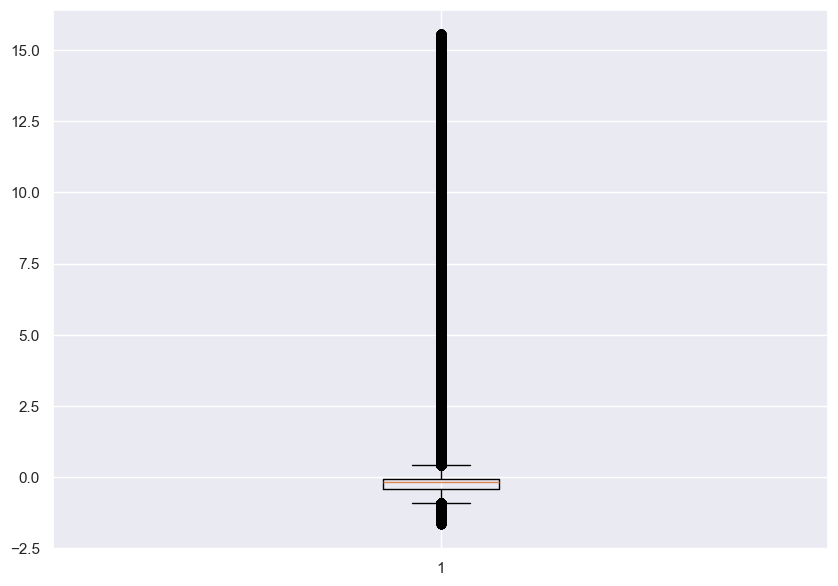

In [28]:
# convert the dataframe to a numpy array, find outliers
features_array_normalized = np.array(features_df_normalized.T)
# still need to find the outliers
fig = plt.figure(figsize=(10, 7))
plt.boxplot(features_array_normalized.flatten())
# here, we notice that most of the data are outliers

Distribution of the dataset with rows as cells and columns as genes

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

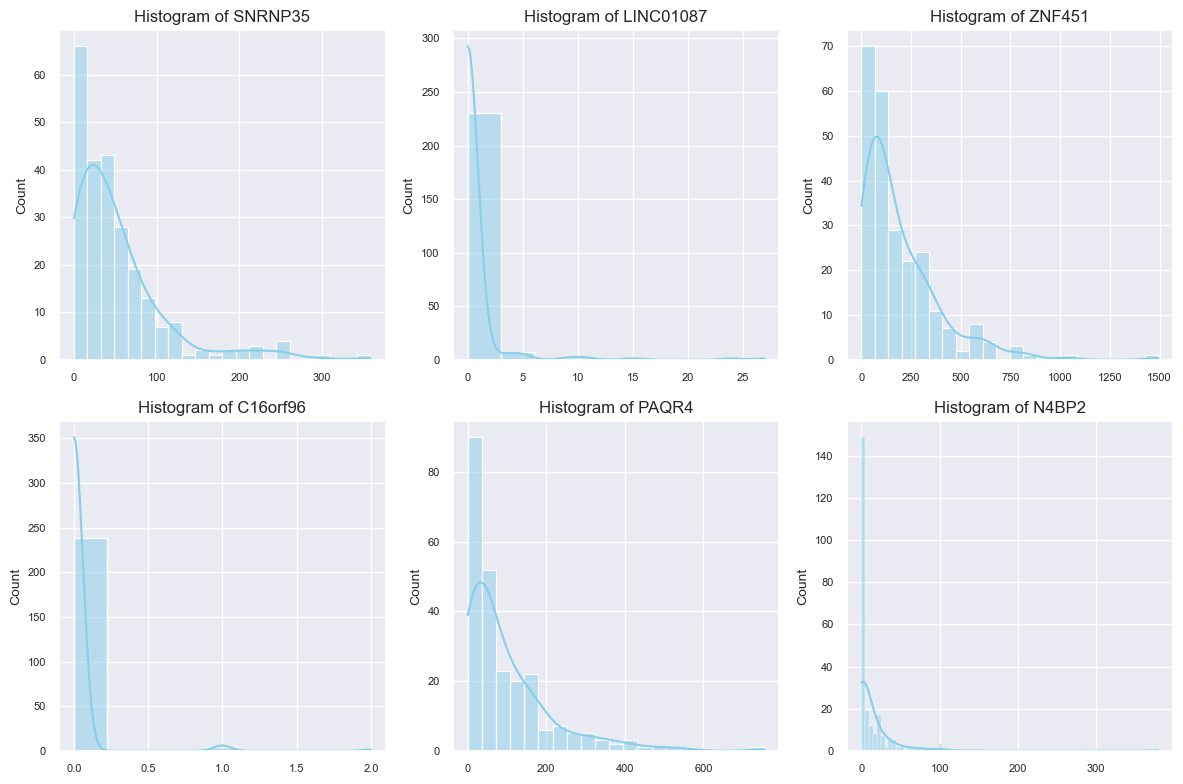

In [26]:
#visualize the distribution of the data through histograms
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 6

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)



fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    sns.histplot(merged[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()



say something like: we see that most of the genes have the following distr:
most of the time 0, then start to decrease and right-skewed

In [27]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_values)

Skewness for each selected feature:
SNRNP35      2.257435
LINC01087    7.124652
ZNF451       2.311733
C16orf96     8.137747
PAQR4        2.198802
N4BP2        7.039415
dtype: float64


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


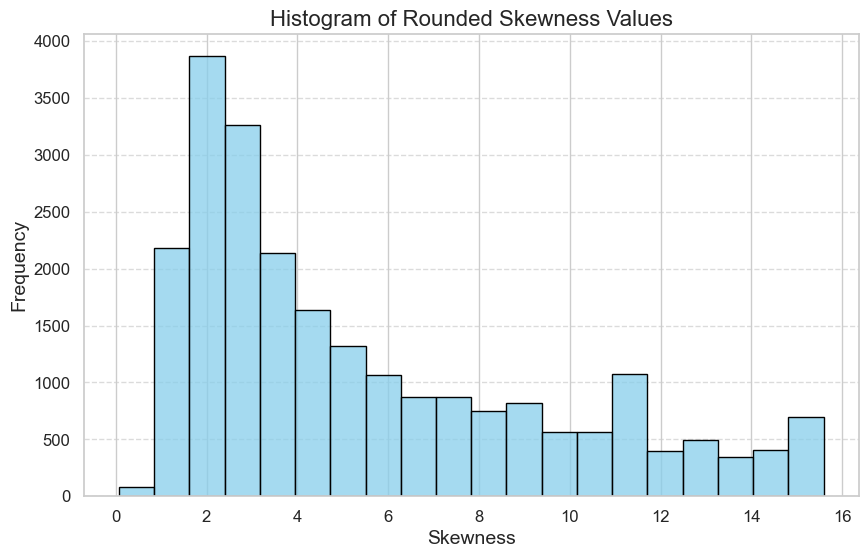

In [28]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged.skew()

# Round the skewness values
rounded_skewness_values = np.round(skewness_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewness_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_values)

Kurtosis for each feature:
SNRNP35       6.323875
LINC01087    56.738590
ZNF451        8.452931
C16orf96     72.786616
PAQR4         6.484577
N4BP2        71.977300
dtype: float64


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


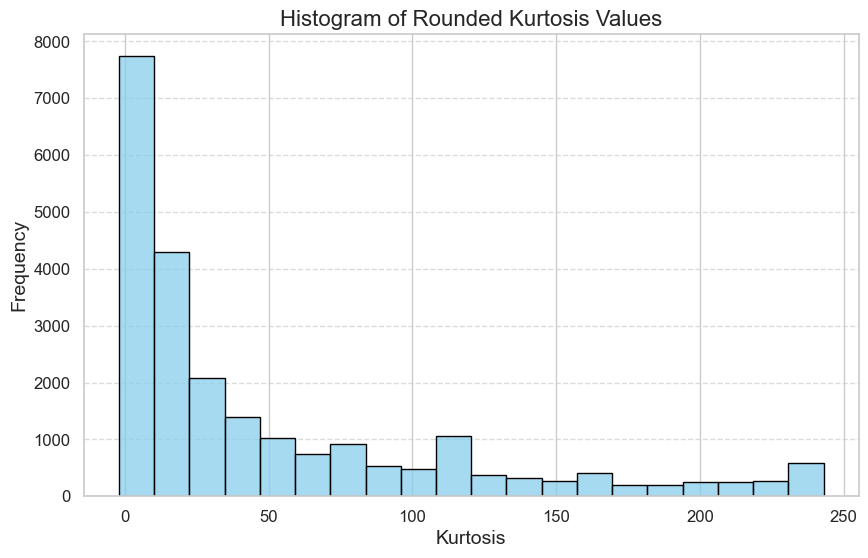

In [30]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged.kurtosis()

# Round the kurtosis values
rounded_kurtosis_values = np.round(kurtosis_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosis_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
# Test the distribution of the data matrix using Kolmogorov-Smirnov
# Test normality of each feature
def test_distribution_per_feature(data):
    non_normal_count = 0
    for column in data.columns:
        p_value = kstest(data[column], 'norm')[1]
        if p_value < 0.05:
            non_normal_count += 1
    print("Number of features with non-normal distribution:", non_normal_count)
    if data.shape[1] == non_normal_count:
        print("All features have non-normal distribution")
    else:
        print("Not all features have non-normal distribution")
    return non_normal_count

non_normal_count = test_distribution_per_feature(merged)


Number of features with non-normal distribution: 23397
All features have non-normal distribution


In [32]:
# Iterate over columns and perform the test
def test_poissondistribution_per_feature(data):
    poisson_list = [] # initialize list to store features with Poisson distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the Poisson distribution)
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(poisson.pmf(value, mean) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a Poisson distribution
        if p >= 0.05:
            poisson_list.append(column)
    print("Number of features that might have poisson distribution:", len(poisson_list))
    if len(poisson_list) == 0:
        print("All features have non-poisson distribution")
    else:
        print("Some features might have poisson distribution")
    return poisson_list

poisson_columns = test_poissondistribution_per_feature(merged)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


Number of features that might have poisson distribution: 3156
Some features might have poisson distribution


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

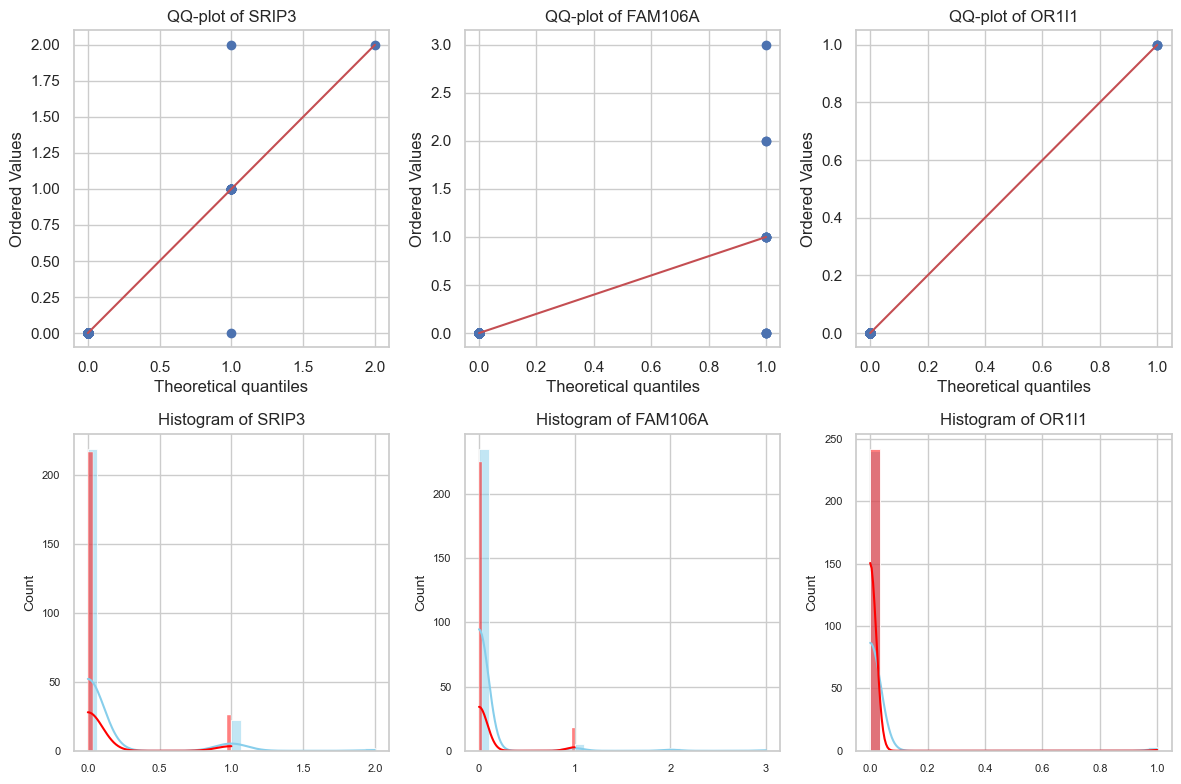

In [33]:
# now we plot the hist of the poisson columns
#now we visualize the empirical distribution against the Gamma distribution for some columns
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(poisson_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    mean = observed_values.mean()
    poisson_values = np.random.poisson(mean, len(observed_values))
    
    stats.probplot(observed_values, dist='poisson', sparams=(mean,), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(poisson_values, kde=True, color='red', label='Gamma', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# Iterate over columns and perform the test
def test_negative_binomial_distribution_per_feature(data):
    nbin_list = [] # initialize list to store features with Gamma distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
        var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
        size = mean ** 2 / (var - mean) # size parameter of the nbinom distribution
        prob = 1 - (mean/var) # probability parameter of the nbinom distribution
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(nbinom.pmf(value, size, prob) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a negative binomial distribution
        if p >= 0.05:
            nbin_list.append(column)
    print("Number of features with Negative Binomial distribution:", len(nbin_list))
    if len(nbin_list) == 0:
        print("All features have non-Negative Binomial distribution")
    else:
        print("Some features might have Negative Binomial distribution")
    return nbin_list

negative_binomial_columns = test_negative_binomial_distribution_per_feature(merged)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/var/folders/l4/fwn11xh17pb5ryvd5h_w9p8r0000gn/T/ipykernel_1715/2698146044.py:19: RuntimeWarning: invalid value encountered in divide
  exp_freq = exp_freq / np.sum(exp_freq)


Number of features with Negative Binomial distribution: 2546
Some features might have Negative Binomial distribution


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

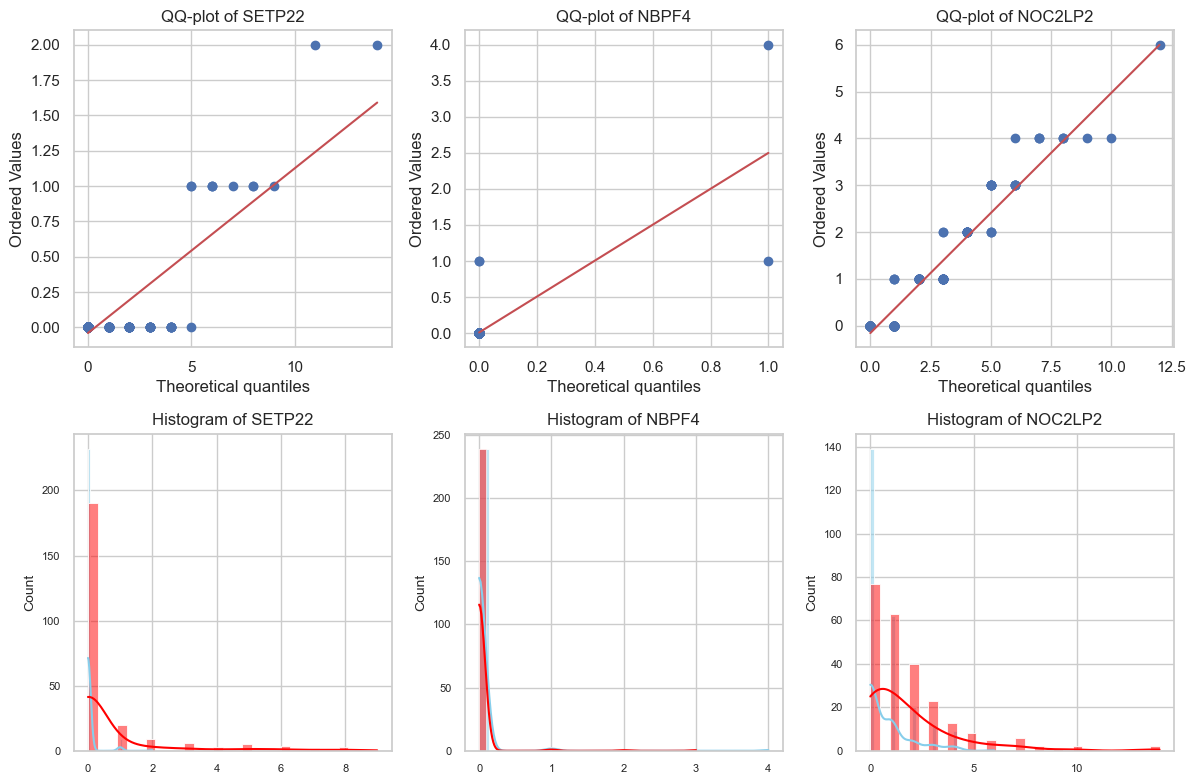

In [35]:
# now we plot the hist of the nbin columns
#now we visualize the empirical distribution against the negative binomial distribution for some columns

np.random.seed(100)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(negative_binomial_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
    var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
    # HERE WE ARE CHEATING WITH THE ABSOLUTE VALUE AND THE "NORMALIZATION" OF THE PROB
    size = abs(mean ** 2 / (var - mean)) # size parameter of the nbinom distribution
    prob = 1 - (mean/var) # probability parameter of the nbinom distribution
    if prob < 0:
        prob = 0
    elif prob > 1:
        prob = 1


    stats.probplot(observed_values, dist='nbinom', sparams=(size,prob), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    plt.title(f'QQ-plot of {column}', fontsize=12)
    nbinom_values = np.random.negative_binomial(size, prob, len(observed_values))
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(nbinom_values, kde=True, color='red', label='Negative Binomial', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# from scipy.stats import gamma

# def test_gamma_distribution_per_feature(data):
#     non_gamma_count = 0
#     for column in data.columns:
#         observed_values = data[column].values  # Observed counts from your data
#         shape, loc, scale = gamma.fit(observed_values)
#         expected_values = gamma.pdf(observed_values, shape, loc, scale) * len(observed_values)
#         expected_values += 1e-10  # Adjust this value if needed

#         contingency_table = [[observed_values[i], expected_values[i]] for i in range(len(observed_values))]

#         chi2, p, _, _ = chi2_contingency(contingency_table)
        
#         # Check if the p-value is less than the significance level
#         if p < 0.05:
#             non_gamma_count += 1
    
#     print("Number of features with non-gamma distribution:", non_gamma_count)

#     if data.shape[1] == non_gamma_count:
#         print("All features have non-gamma distribution")
#     else:
#         print("Not all features have non-gamma distribution")
        
#     return non_gamma_count

# test_gamma_distribution_per_feature(merged)

# # eventually run this and maybe also plot it

In [29]:
#now we check the distribution but for hypoxia and normoxia separtely
merged_norm = merged[merged['Target'] == 0]
merged_hypo = merged[merged['Target'] == 1]

In [30]:
print("Number of normoxia samples:", merged_norm.shape[0])
test_distribution_per_feature(merged_norm)
print("Number of hypoxia samples:", merged_hypo.shape[0])
test_distribution_per_feature(merged_hypo)

Number of normoxia samples: 126


NameError: name 'test_distribution_per_feature' is not defined

In [31]:
print("Number of normoxia samples:", merged_norm.shape[0])
test_negative_binomial_distribution_per_feature(merged_norm)
print("Number of hypoxia samples:", merged_hypo.shape[0])
test_negative_binomial_distribution_per_feature(merged_hypo)

Number of normoxia samples: 126


NameError: name 'test_negative_binomial_distribution_per_feature' is not defined

Correlation 

NB: we already did it for the cells (duplicates task), now we do it for the genes and moreover we extend the analysis of the first.

In [40]:
# We will use pytorch correlation matrix to calculate the correlation matrix usint torch.corrcoef
# Correlation matrix between the genes (features)

# Convert the DataFrame to a PyTorch tensor
data_tensor = th.tensor(merged.values).T
# Calculate the correlation matrix
correlation_matrix = th.corrcoef(data_tensor)
print(correlation_matrix)
# Nicely visuaize the correlation matrix
# plt.figure(figsize=(12,10))
# sns.heatmap(correlation_matrix, cmap='coolwarm', yticklabels = False, xticklabels = False)
# plt.xlabel('Sample')
# plt.ylabel('Sample')
# plt.show()

# Compute the midpoint
midpoint = (correlation_matrix.max() - correlation_matrix.min()) / 2 + correlation_matrix.min()
# Print the size of the correlation matrix
print("Size of the correlation matrix: ", correlation_matrix.shape)
# Print average and minimum correlation values
print("Average correlation between cells: ", float(midpoint))
print("Minimum correlation between cells: ", float(correlation_matrix.min()), "\n")

tensor([[ 1.0000,  0.0587,  0.1681,  ...,  0.0077,  0.0771, -0.0077],
        [ 0.0587,  1.0000, -0.0315,  ...,  0.0255,  0.0088, -0.0828],
        [ 0.1681, -0.0315,  1.0000,  ...,  0.0910, -0.0589, -0.1241],
        ...,
        [ 0.0077,  0.0255,  0.0910,  ...,  1.0000,  0.2880,  0.0993],
        [ 0.0771,  0.0088, -0.0589,  ...,  0.2880,  1.0000,  0.0506],
        [-0.0077, -0.0828, -0.1241,  ...,  0.0993,  0.0506,  1.0000]])
Size of the correlation matrix:  torch.Size([23397, 23397])
Average correlation between cells:  0.2018159031867981
Minimum correlation between cells:  -0.5963682532310486 



torch.Size([243, 23397])
torch.Size([243, 243])
Indices of the minimum value in the correlation matrix:  (tensor([153]), tensor([33]))
Cell names with minimum correlation: output.STAR.PCRPlate3D11_Normoxia_S92_Aligned.sortedByCoord.out.bam, output.STAR.PCRPlate1D3_Hypoxia_S6_Aligned.sortedByCoord.out.bam


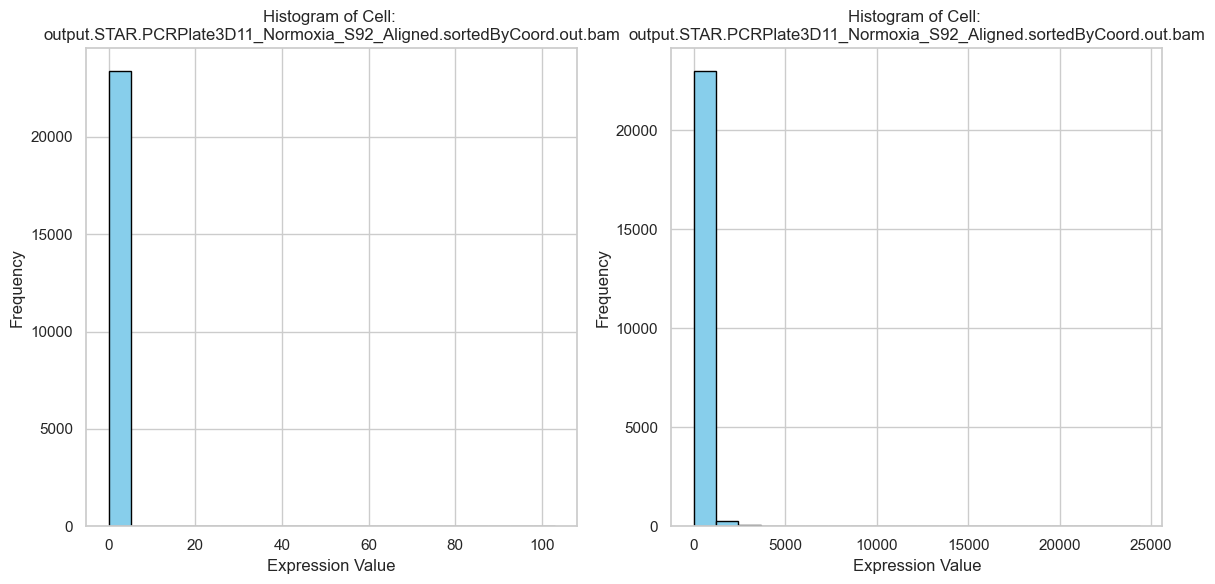

In [41]:
# We can see from the minimum value obtained that there are some cells that are 
# completely uncorrelated from the others and we want to see why
# Find the indices of the minimum value in the correlation matrix
data_tensor_transpose = data_tensor.T
print(data_tensor_transpose.shape)
correlation_matrix_transpose = th.corrcoef(data_tensor_transpose)
print(correlation_matrix_transpose.shape)
min_indices = th.where(correlation_matrix_transpose == correlation_matrix_transpose.min())
print("Indices of the minimum value in the correlation matrix: ", min_indices)
# Transform min_indices to a list
value1 = min_indices[0].item()
value2 = min_indices[1].item()
# Access rows with index value1 and value2
cells_identified = merged.iloc[[value1, value2]]
print(f"Cell names with minimum correlation: {cells_identified.index[0]}, {cells_identified.index[1]}")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(data_tensor_transpose[min_indices[0]], bins=20, color='skyblue', edgecolor='black')
# set title with corresponding cell index

axs[0].set_title(f'Histogram of Cell: \n{cells_identified.index[0]}', fontsize=12)
axs[0].set_xlabel('Expression Value', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[1].hist(data_tensor_transpose[min_indices[1]], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title(f'Histogram of Cell: \n{cells_identified.index[0]}', fontsize=12)
axs[1].set_xlabel('Expression Value', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


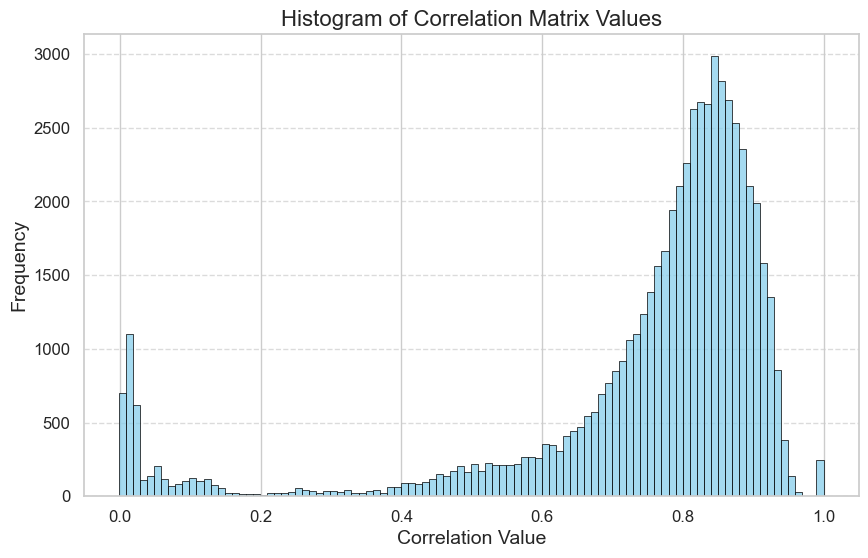

In [42]:
# Correlation between cells (samples)
# Plot histogram of the values to see the distribution
data_tensor = th.tensor(merged.values)
correlation_matrix_transpose = th.corrcoef(data_tensor)
plt.figure(figsize=(10, 6))
sns.histplot(correlation_matrix_transpose.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values', fontsize=16)
plt.xlabel('Correlation Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Clear that we have peaks at high correlation values between cells. In principle, this is explained by the fact that every 
# gene expression in the table is coming from the same cell line we expect overall an high correlation among them.

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/filipporonzino/anaconda3/lib/python3.11/site-pa

(243, 243)


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/

[]

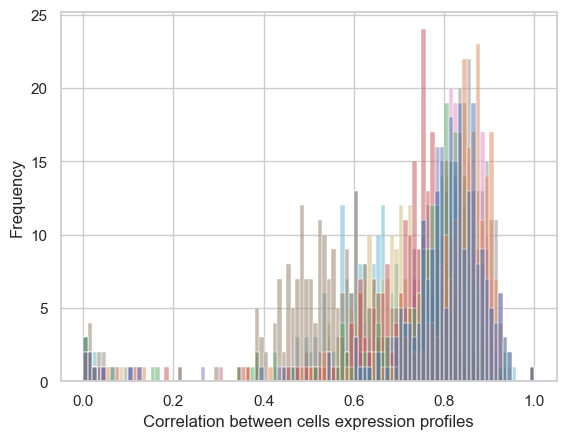

In [43]:
# We now can plot the distribution of the correlation between gene expression profiles using a 
# histogram (we do it on the first ten variables)

correlation_matrix = pd.DataFrame(correlation_matrix_transpose)
print(correlation_matrix.shape)
c_subset = correlation_matrix.iloc[:,:10]
sns.histplot(c_subset,bins=100)
plt.legend().set_visible(False)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')
plt.plot()


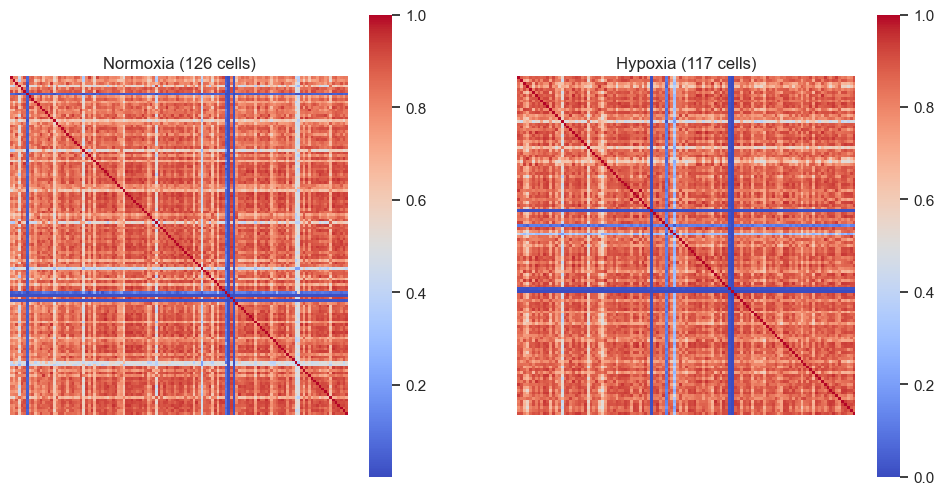

Shape of correlation matrix for normoxia: torch.Size([126, 126])
Shape of correlation matrix for hypoxia: torch.Size([117, 117])


In [44]:
# Now let us inspect if the correlation is different between the two classes
# We can do this by plotting the correlation matrix for each class separately
# We can do this by splitting the dataframe into two dataframes, one for each class


# Convert the DataFrames to PyTorch tensors
data_tensor_norm = th.tensor(merged_norm.values)
data_tensor_hypo = th.tensor(merged_hypo.values)

# Calculate the correlation matrices
correlation_matrix_norm = th.corrcoef(data_tensor_norm)
correlation_matrix_hypo = th.corrcoef(data_tensor_hypo)

# Plot the correlation matrices with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(correlation_matrix_norm, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[0], square=True)
sns.heatmap(correlation_matrix_hypo, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[1], square=True)
# Set titles with number of genes that are norm or hypo
axs[0].set_title(f'Normoxia ({merged_norm.shape[0]} cells)')
axs[1].set_title(f'Hypoxia ({merged_hypo.shape[0]} cells)')
plt.show() 

# Check shape of correlation matrices
print("Shape of correlation matrix for normoxia:", correlation_matrix_norm.shape)
print("Shape of correlation matrix for hypoxia:", correlation_matrix_hypo.shape)

________________________________________________________________________________________________________________________
We do the same for the transpose dataset (genes as rows and cells as columns):

In [32]:
# we simply transpose again the dataframe (now we have cells as columns)
print("Dataframe dimension before transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt = df_seq_HUnfilt.T
print("Dataframe dimension after transpose:", df_seq_HUnfilt.shape)
df_seq_HUnfilt.head(5)

Dataframe dimension before transpose: (243, 23396)
Dataframe dimension after transpose: (23396, 243)


,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
WASH7P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CICP27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDX11L17,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASH9P,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
OR4F29,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:

print("Missing values in the dataframe by columns:", df_seq_HUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_HUnfilt.isna().sum().sum())

Missing values in the dataframe by columns: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        0
                                                                       ..
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     0
Length: 243, dtype: int64
Missing values in the whole dataframe: 0


In [34]:
df_seq_HUnfilt.describe()

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
count,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,...,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000
mean,99.565695,207.678278,9.694734,150.689007,35.700504,47.088434,152.799453,135.869422,38.363908,45.512139,...,76.361771,105.566593,54.026116,29.763806,28.905411,104.740725,35.181569,108.197940,37.279962,76.303855
std,529.532443,981.107905,65.546050,976.936548,205.885369,545.367706,864.974182,870.729740,265.062493,366.704721,...,346.659348,536.881574,344.068304,186.721266,135.474736,444.773045,170.872090,589.082268,181.398951,369.090274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
75%,51.000000,125.000000,5.000000,40.000000,22.000000,17.000000,81.000000,76.000000,22.000000,18.000000,...,56.000000,67.000000,29.000000,18.000000,19.000000,76.000000,24.000000,68.000000,22.000000,44.000000
max,35477.000000,69068.000000,6351.000000,70206.000000,17326.000000,47442.000000,43081.000000,62813.000000,30240.000000,35450.000000,...,19629.000000,30987.000000,21894.000000,13457.000000,11488.000000,33462.000000,15403.000000,34478.000000,10921.000000,28532.000000


In [35]:
# Just renaming
mergedT = df_seq_HUnfilt

Outliers for the transpose dataset (rows are genes)

In [49]:
# # TO REVIEW
# np.random.seed(42)

# # Number of boxplots you want to create
# num_boxplots = 5

# # Randomly select column indices
# random_columns = np.random.choice(mergedT.columns[1:], num_boxplots, replace=False)


# plt.figure(figsize=(12, 8))  
# for i, column in enumerate(random_columns):
#     plt.subplot(1, len(random_columns), i+1)
    
#     # Customizing boxplot appearance
#     sns.boxplot(y=mergedT[column], color='skyblue', width=0.5)
    
#     # Overlaying swarmplot for better visualization of individual data points
#     sns.swarmplot(y=mergedT[column], color='red', alpha=0.5)
    
#     plt.title(f'Boxplot of {column}', fontsize=14)
#     plt.ylabel('Count of the gene expression', fontsize=12)
#     plt.xlabel('', fontsize=12)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.grid(True)


# plt.tight_layout()
# plt.show()

In [50]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = mergedT.quantile(0.25)
Q3 = mergedT.quantile(0.75)
IQR = Q3 - Q1
outliers = (mergedT < (Q1 - 1.5 * IQR)) | (mergedT > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

Number of outliers in the DataFrame: output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    3512
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     3385
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       3442
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      5021
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        3336
                                                                        ... 
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    3120
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    3211
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      3253
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     3403
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     3394
Length: 243, dtype: int64
13.89%


In [51]:
# edo

Now we analyze distribution of the transpose dataset (rows are genes)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


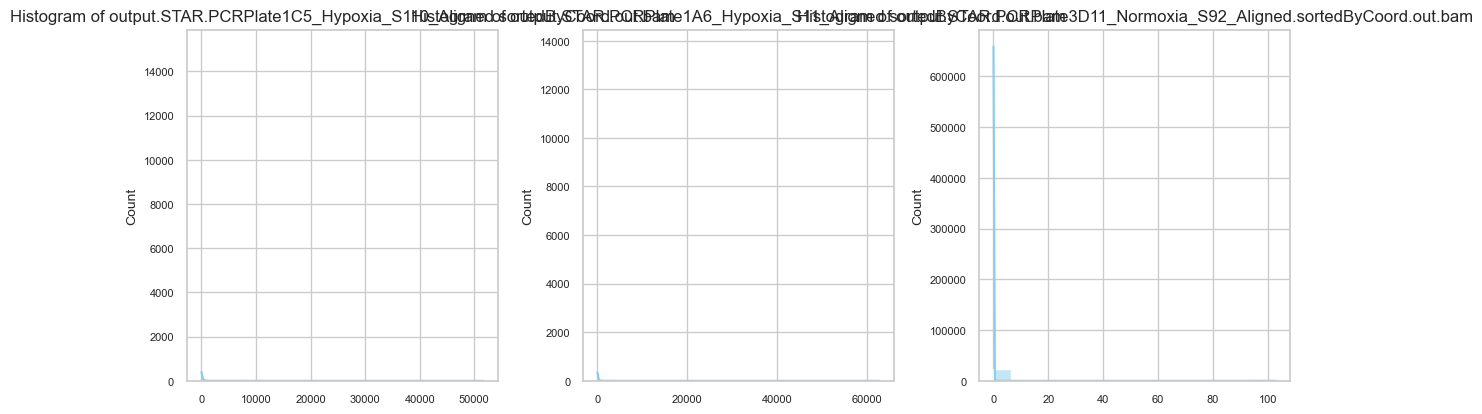

In [52]:
#visualize the distribution of the data through histograms
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(mergedT.columns[1:], num_boxplots, replace=False)



fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    sns.histplot(mergedT[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    # rescale the y-axis to better visualize the distribution
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_valuesT)

Skewness for each selected feature:
output.STAR.PCRPlate1C5_Hypoxia_S110_Aligned.sortedByCoord.out.bam      31.918552
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam       38.165815
output.STAR.PCRPlate3D11_Normoxia_S92_Aligned.sortedByCoord.out.bam    148.458666
dtype: float64


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


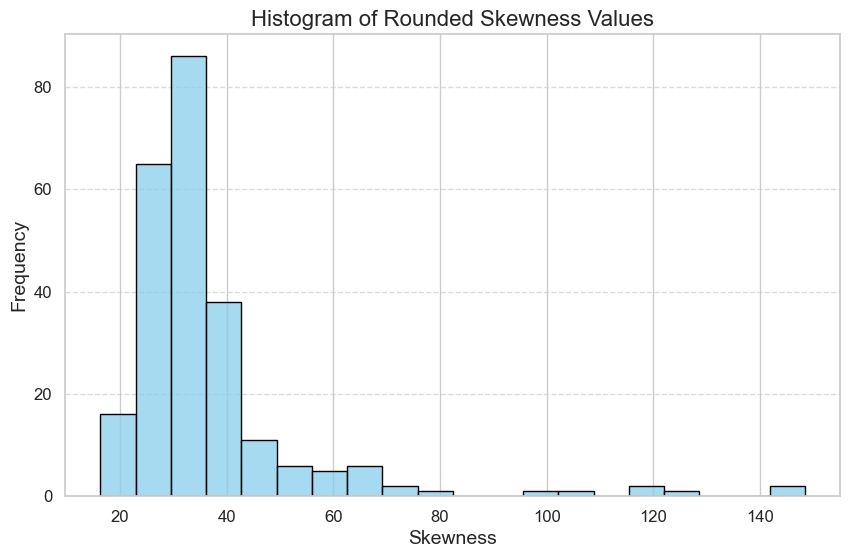

In [54]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT.skew()

# Round the skewness values
rounded_skewnessT_values = np.round(skewness_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewnessT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_valuesT)

Kurtosis for each feature:
output.STAR.PCRPlate1C5_Hypoxia_S110_Aligned.sortedByCoord.out.bam      1412.998988
output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam       2090.435332
output.STAR.PCRPlate3D11_Normoxia_S92_Aligned.sortedByCoord.out.bam    22445.475692
dtype: float64


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


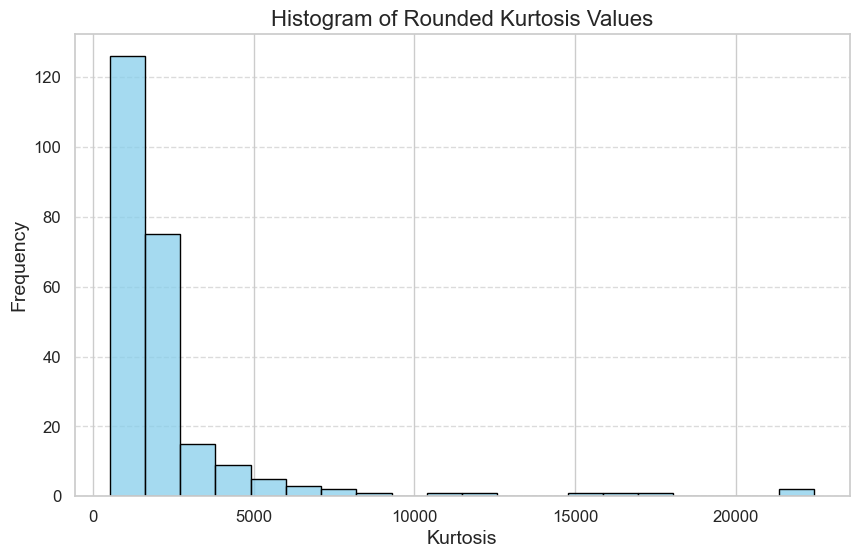

In [56]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT.kurtosis()

# Round the kurtosis values
rounded_kurtosisT_values = np.round(kurtosis_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosisT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [57]:
# Test normality using the Kolmogorov-Smirnov test impl. before
non_normal_countT = test_distribution_per_feature(mergedT)

Number of features with non-normal distribution: 243
All features have non-normal distribution


In [58]:
# Now test other distribition in the same way
test_poissondistribution_per_feature(mergedT)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


Number of features that might have poisson distribution: 0
All features have non-poisson distribution


[]

In [59]:
test_negative_binomial_distribution_per_feature(mergedT)

Number of features with Negative Binomial distribution: 0
All features have non-Negative Binomial distribution


[]

In [60]:
# test_gamma_distribution_per_feature(mergedT)

NameError: name 'test_gamma_distribution_per_feature' is not defined

In [ ]:
# DA AGGIUNGERE REPR FOR GAMMA

________________________________________________________________________________________________________________________

Normalization, now we will work on the transpose dataset (genes as rows and cells as columns)

In [61]:
mergedT.shape

(23396, 243)

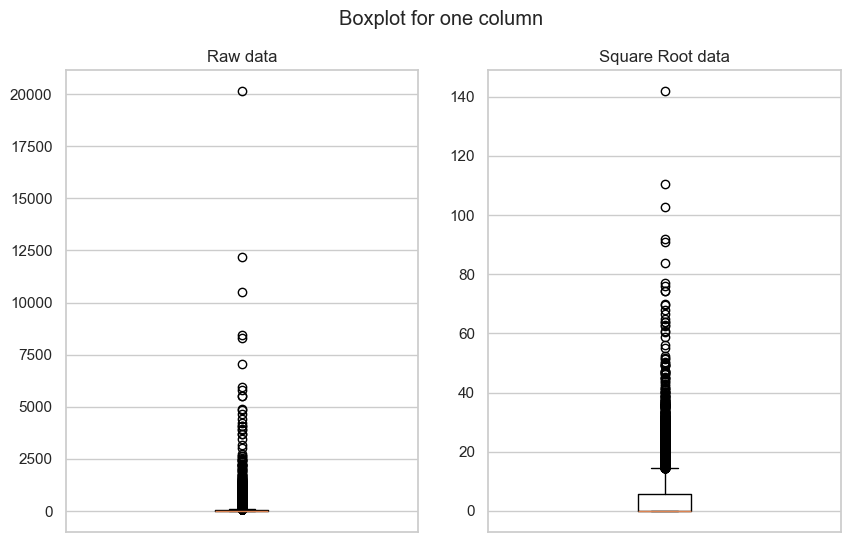

In [63]:
# Highly non normal distribution hence we take concave transformations the features
# Inspect first a single randomly selected feature

# we are using the transposed dataset

# Select a random index with seed
np.random.seed(42)
randomindex = np.random.randint(0, mergedT.shape[1])

# Apply the square root of the feature with random index
mergedT_squareroot = np.sqrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_squareroot)
axs[1].set_title("Square Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

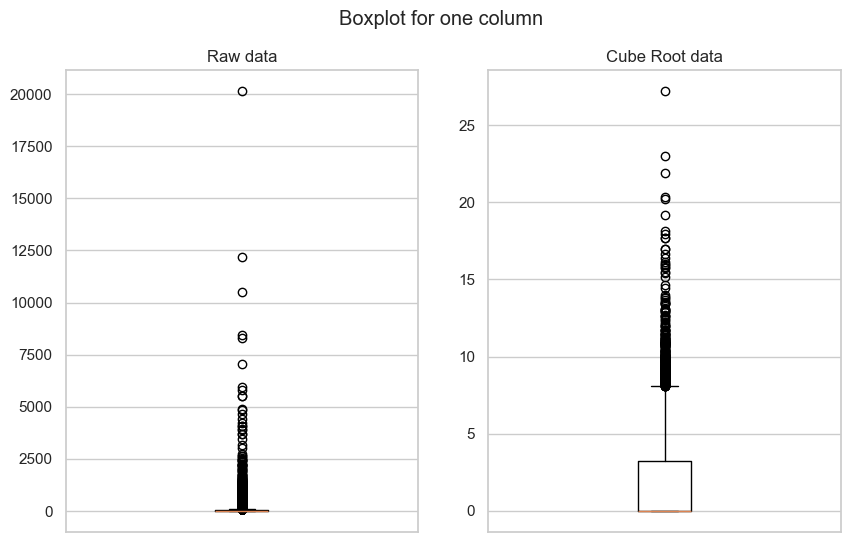

In [64]:
mergedT_cuberoot = np.cbrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_cuberoot)
axs[1].set_title("Cube Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

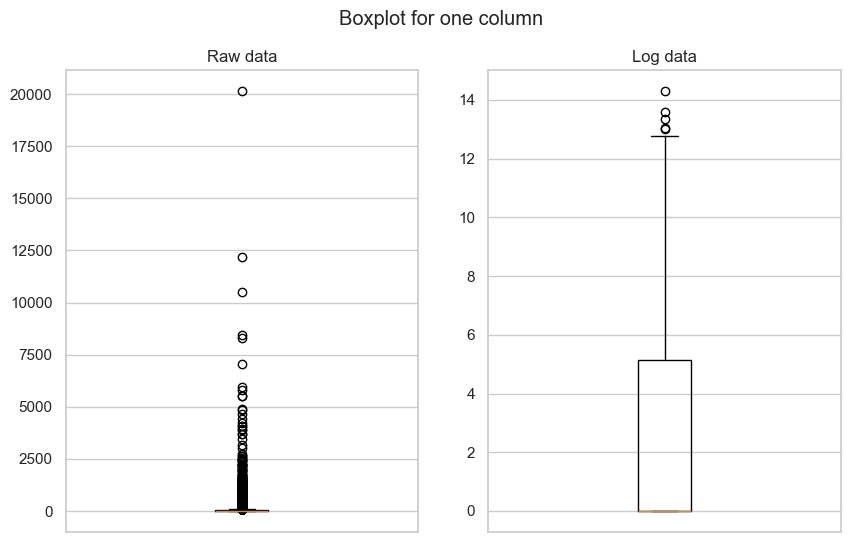

In [65]:
mergedT_log2_onecol = np.log2(mergedT[mergedT.columns[randomindex]]+1)
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_log2_onecol)
axs[1].set_title("Log data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

Skewness of raw data: 33.03071732955048
Skewness of log transformed data: 0.7474895820918155
Skewness of square root transformed data: 3.815720377409044
Skewness of cube root transformed data: 1.516140830965163


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


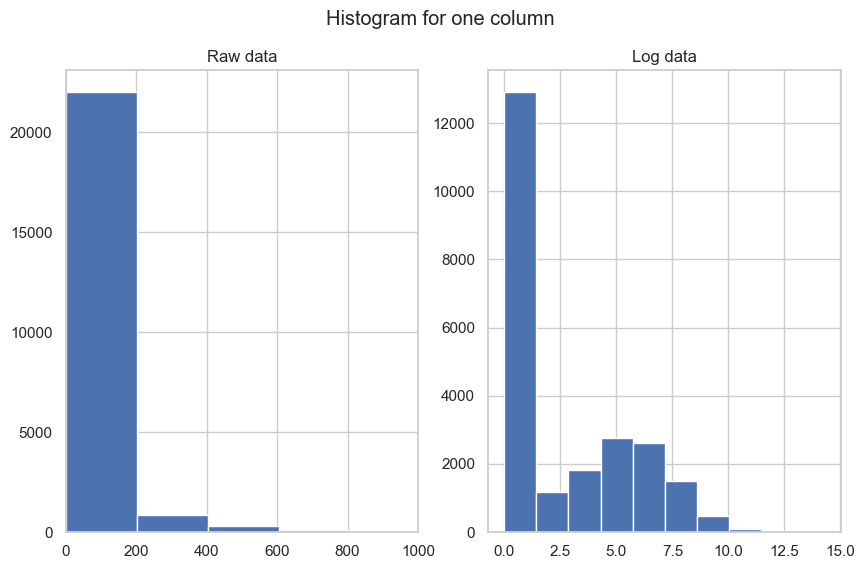

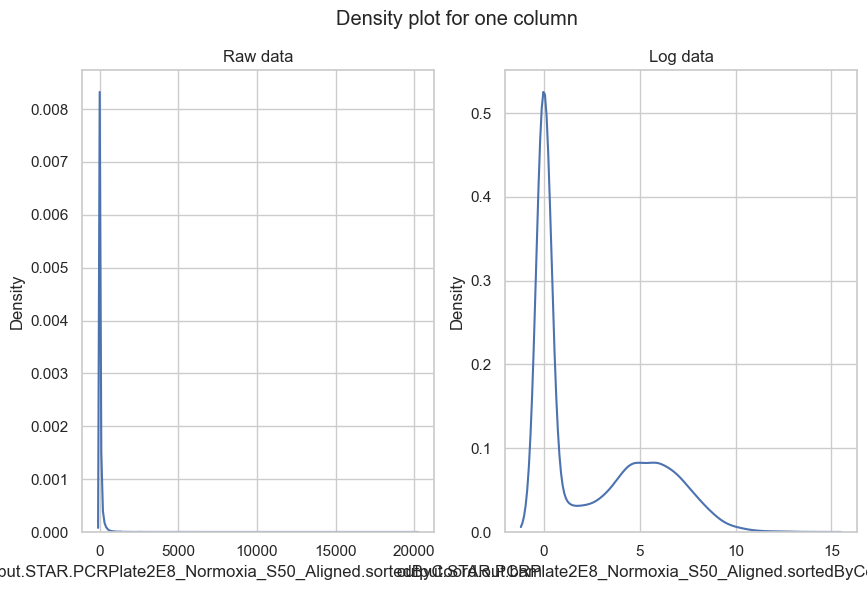

In [66]:
# Prove that log transformation is the best
# Calculate the skewness of the raw data
skewness_raw = mergedT[mergedT.columns[randomindex]].skew()
# Calculate the skewness of the log transformed data
skewness_log = np.log2(mergedT[mergedT.columns[randomindex]]+1).skew()
# Calculate the skewness of the square root transformed data
skewness_sqrt = np.sqrt(mergedT[mergedT.columns[randomindex]]).skew()
# Calculate the skewness of the cube root transformed data
skewness_cbrt = np.cbrt(mergedT[mergedT.columns[randomindex]]).skew()
# Print the skewness values
print(f"Skewness of raw data: {skewness_raw}")
print(f"Skewness of log transformed data: {skewness_log}")
print(f"Skewness of square root transformed data: {skewness_sqrt}")
print(f"Skewness of cube root transformed data: {skewness_cbrt}")

# Plot the histogram of transformed column, inspect why the skewness is negative
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Histogram for one column")
axs[0].hist(mergedT[mergedT.columns[randomindex]], bins = 100)
# Set x-axis limit
axs[0].set_xlim(0, 1000)
axs[0].set_title("Raw data")
axs[0].grid(True)
axs[1].hist(mergedT_log2_onecol)
axs[1].set_title("Log data")
axs[1].grid(True)

# Plot the density of the transformed column
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Density plot for one column")
sns.kdeplot(mergedT[mergedT.columns[randomindex]], ax=axs[0])
axs[0].set_title("Raw data")
axs[0].grid(True)
sns.kdeplot(mergedT_log2_onecol, ax=axs[1])
axs[1].set_title("Log data")
axs[1].grid(True)


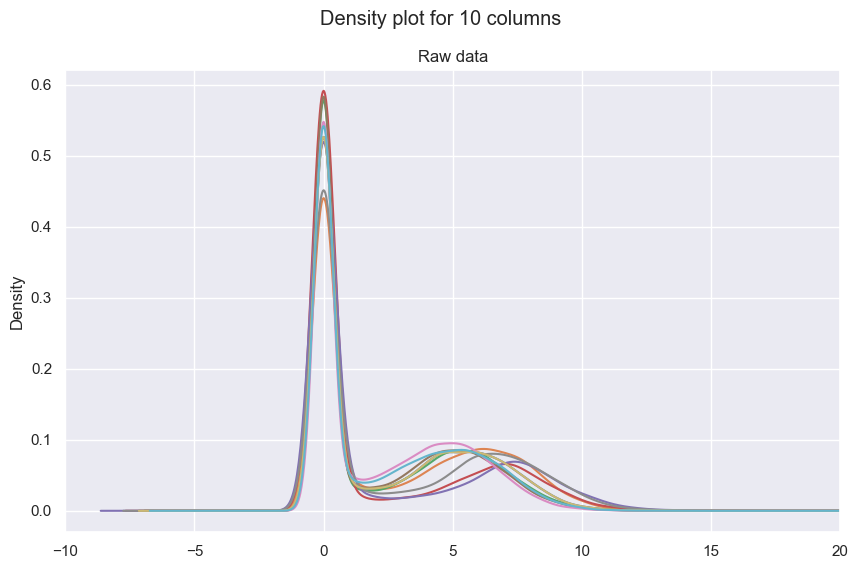

In [45]:
# Plot the densities of 10 randomly selected features all in one plot with sns with rescaled x axis
np.random.seed(42)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot for 10 columns")
for i in np.random.randint(0, mergedT.shape[1], 10):
    np.log2(mergedT[mergedT.columns[i]]+1).plot.density(legend = False)
ax.set_title("Raw data")
# Rescale x limits
ax.set_xlim(-10, 20)
plt.grid(True)
ax.grid(True)
plt.show()



DA CAMBIARE What can we say about these results? We see that there are two peaks, so close to half of the genes are usually not expressed (or very low expressed) while roughly the other half is very expressed. So, this indicates the presence of two subgroups of genes for each cell. In classification, we want to "compare" these distributions, but from the boxplot above, we can see that different samples have different expression levels range, which complicates the task!

Skewness of log transformed data: 1.9448128089514012
Skewness of cube root transformed data: 2.564395004670237
Skewness of square root transformed data: 5.848957458216953


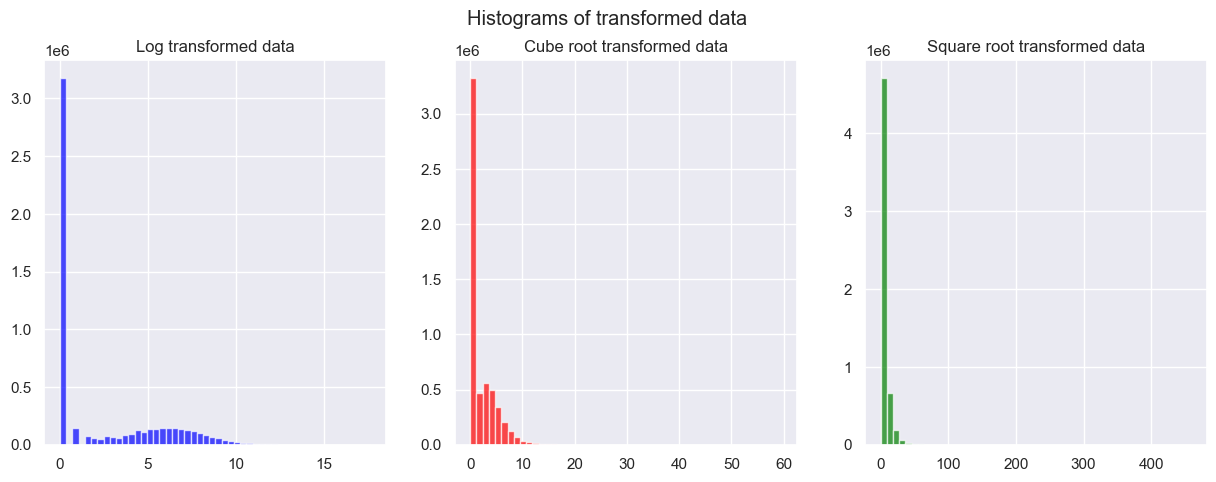

In [36]:
# Ideally we see log worked the best for this randomly selected random feature, now we apply the 3 on all the dataset
# Apply the log transformation to the entire dataset
mergedT_log = np.log2(mergedT+1)
mergedT_cbrt = np.cbrt(mergedT)
mergedT_sqrt = np.sqrt(mergedT)
# Convert to DataFrame
mergedT_log = pd.DataFrame(mergedT_log, columns=mergedT.columns, index=mergedT.index)
mergedT_cbrt = pd.DataFrame(mergedT_cbrt, columns=mergedT.columns, index=mergedT.index)
mergedT_sqrt = pd.DataFrame(mergedT_sqrt, columns=mergedT.columns, index=mergedT.index)
# Check skewness of the transformed data
skewness_log = mergedT_log.skew()
skewness_cbrt = mergedT_cbrt.skew()
skewness_sqrt = mergedT_sqrt.skew()
# Print the skewness values
print(f"Skewness of log transformed data: {skewness_log.mean()}")
print(f"Skewness of cube root transformed data: {skewness_cbrt.mean()}")
print(f"Skewness of square root transformed data: {skewness_sqrt.mean()}")
# Plot the histograms of the transformed data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("Histograms of transformed data")
axs[0].hist(mergedT_log.values.flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title("Log transformed data")
axs[1].hist(mergedT_cbrt.values.flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title("Cube root transformed data")
axs[2].hist(mergedT_sqrt.values.flatten(), bins=50, color='green', alpha=0.7)
axs[2].set_title("Square root transformed data")
plt.show()

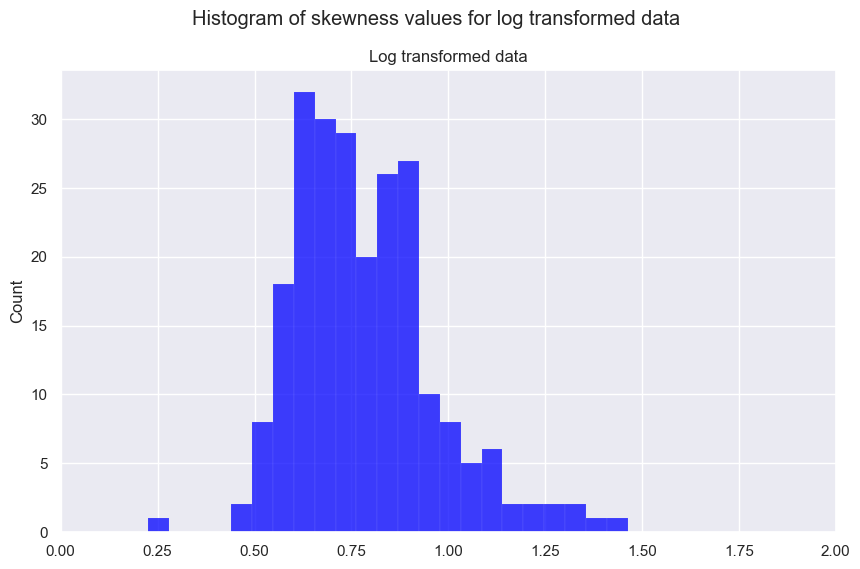

In [37]:
# Create a list of skewness values for all columns
skewness_log = mergedT_log.skew()

# Now we histogram plot the skewness values for the log transformed data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Histogram of skewness values for log transformed data")
sns.histplot(skewness_log, bins=1000, color='blue')
ax.set_title("Log transformed data")
# Set x limits
ax.set_xlim(0, 2)
plt.grid(True)
plt.show()


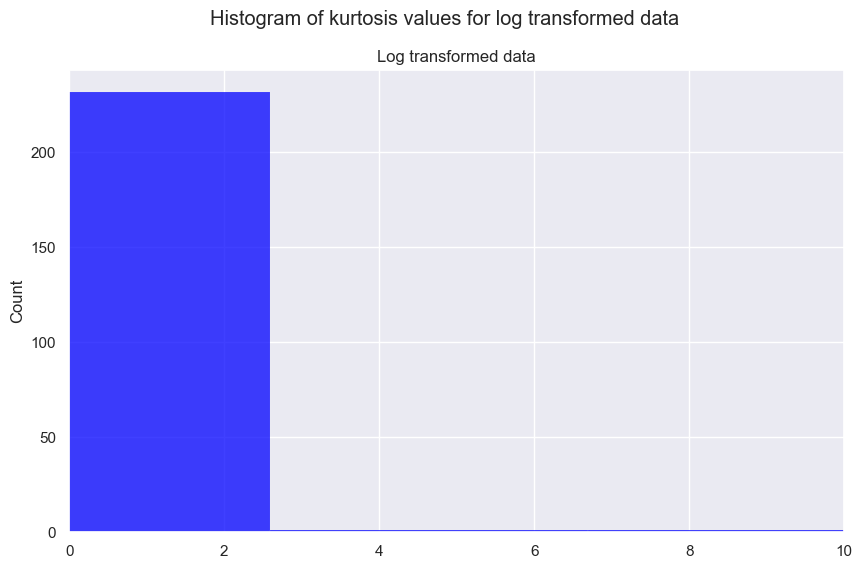

In [38]:
# kurtosis of log-trasnformed dataframe computed one column at a time
kurtosis_log = mergedT_log.kurtosis()
# Plot the histogram of kurtosis values
fig = plt.figure(figsize=(10,6))
plt.suptitle("Histogram of kurtosis values for log transformed data")
sns.histplot(kurtosis_log, bins=1000, color='blue')
plt.title("Log transformed data")
plt.xlim(0, 10)
plt.grid(True)
plt.show()

We use CPM (Counts Per Million) normalization, which is a common normalization technique for RNA-seq data.
CPM values are calculated by dividing the number of readings mapped to a gene by a million scaling factor divided by the total of mapped reads.
We will do it across columns (i.e. across cells) because we want the genes' readings to be "normalized" and so comparable across different observations

In [39]:
# CPM Normalization with a for loop
# Initialize a new DataFrame
mergedT_cpm = pd.DataFrame()
# Loop over each column
for column in mergedT.columns:
    # Calculate the CPM
    cpm = mergedT[column] / mergedT[column].sum() * 1e6
    # Add the CPM to the new DataFrame
    mergedT_cpm = pd.concat([mergedT_cpm, cpm], axis=1)


In [40]:
mergedT_cpm.shape

(23396, 243)

In [41]:
mergedT_cpm.head()

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
WASH7P,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
CICP27,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
DDX11L17,0.000000,0.0,0.0,0.0,0.0,0.907704,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
WASH9P,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.114129,0.0,...,0.0,0.0,0.0,0.0,0.0,0.408078,0.0,0.395038,0.0,0.0
OR4F29,0.858576,0.0,0.0,0.0,0.0,0.000000,0.279728,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [74]:
mergedT_cpm.describe()

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
count,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,...,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000
mean,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,...,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349,42.742349
std,227.321876,201.922208,288.980813,277.104242,246.495798,495.032325,241.957859,273.917663,295.313853,344.387709,...,194.037339,217.375394,272.207014,268.141298,200.326105,181.501940,207.593767,232.710161,207.978141,206.749518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.559735,0.000000,0.000000,0.000000,0.000000,0.816155,0.000000,0.000000,0.000000,0.560160
75%,21.893683,25.726300,22.044106,11.345844,26.339451,15.430964,22.658002,23.908386,24.510842,16.904551,...,31.345155,27.127307,22.943129,25.848922,28.095246,31.013902,29.157778,26.862616,25.223515,24.647029
max,15229.847186,14214.912569,28000.423247,19913.658127,20743.514808,43063.282384,12050.979945,19759.966100,33691.265896,33292.574582,...,10987.036539,12546.177155,17321.271049,19324.941050,16987.272854,13655.094401,18713.218678,13620.136533,12521.182020,15982.478203


Here we boxplot our CPM-normalized cells. The distributions start to look balanced.

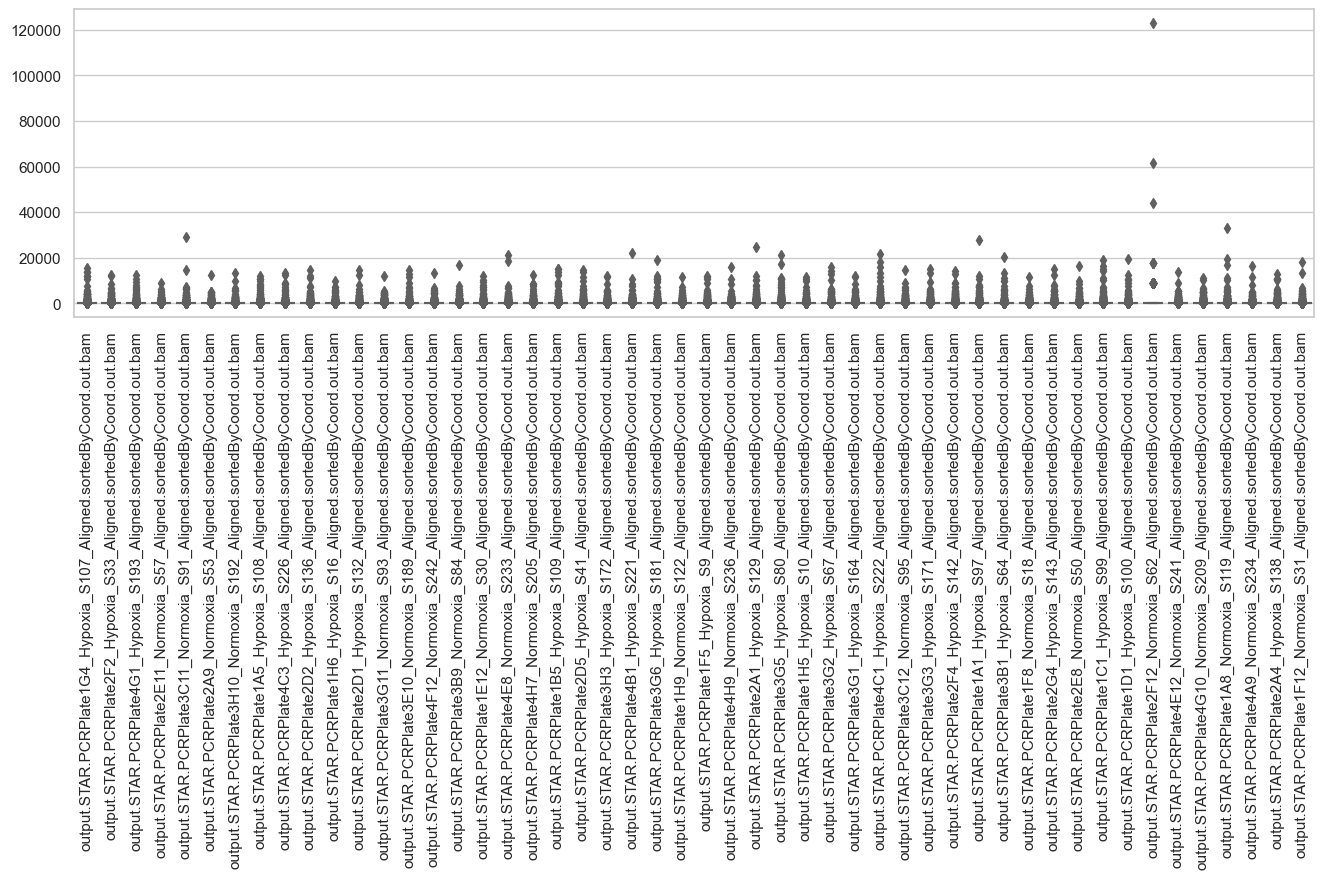

In [75]:
#box-plot of log-transformed 50 random columns of dataframe
random_columns = list(range(0, mergedT.shape[1])) # list of integers from 1 to 243
random.shuffle(random_columns)
random_columns = random_columns[:50]
normalized_small = mergedT_cpm.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=normalized_small,palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);


Here we see that the Skeweness and Kurtosis values are still very high.The log transformation will definitely improve the symmetry of the distributions.

Mean Skewness of CPM normalized data: 36.75347845354624
Mean Kurtosis of CPM normalized data: 2396.648936441014


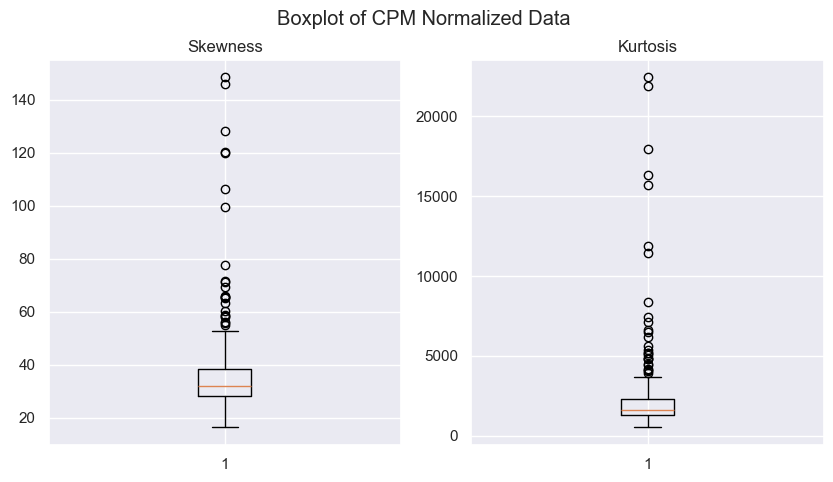

In [42]:
# Check again skewness and kurtosis of the CPM normalized data
skewness_cpm = mergedT_cpm.skew()
kurtosis_cpm = mergedT_cpm.kurtosis()
# Print the skewness and kurtosis values
print(f"Mean Skewness of CPM normalized data: {skewness_cpm.mean()}")
print(f"Mean Kurtosis of CPM normalized data: {kurtosis_cpm.mean()}")
# boxplot of skewness
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle("Boxplot of CPM Normalized Data")
ax[0].boxplot(skewness_cpm)
ax[0].grid(True)
ax[0].set_title("Skewness")
ax[1].boxplot(kurtosis_cpm)
ax[1].grid(True)
ax[1].set_title("Kurtosis")
plt.show()


In [43]:
# Now we will apply the log transformation to the CPM normalized data
mergedT_cpm_log = np.log2(mergedT_cpm+1)
# Convert to DataFrame
mergedT_cpm_log = pd.DataFrame(mergedT_cpm_log, columns=mergedT_cpm.columns, index=mergedT_cpm.index)

The boxplot of 50 random cells shows that the distributions after the log transformation are even more balanced and symmetric.

In [44]:
# Study the distributions of 50 random columns now (boxplot and densities)
log_small = mergedT_cpm_log.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=log_small, palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);


NameError: name 'random_columns' is not defined

Plotting the densities of 10 random cells, we notice a Bimodal distributions, with of course a peak at the 0, as we expected since most of the genes in each cell have 0 reading, and a second peak around 5, so this means that most of the genes, when they apprear, have a similar number of readings.

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

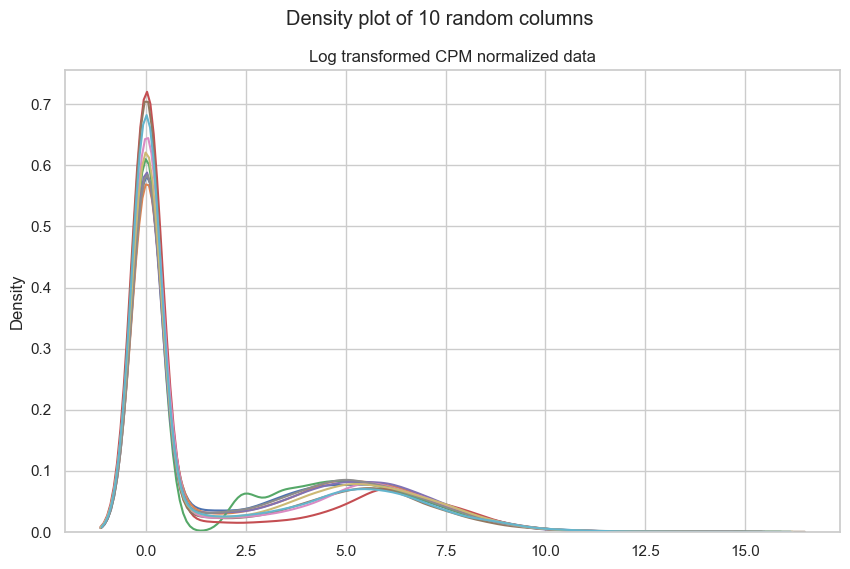

In [79]:
# Densities of the 10 random columns
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot of 10 random columns")
for i in range(10):
    sns.kdeplot(mergedT_cpm_log.iloc[:, i], ax=ax)
ax.set_title("Log transformed CPM normalized data")
ax.set_xlabel("")
ax.grid(True)
plt.show()


In [ ]:
# from scipy.stats import beta

# # Iterate over columns and perform the test
# def test_beta_distribution_per_feature(data):
#     beta_list = [] # initialize list to store features with Gamma distribution
#     for column in data.columns:
#         observed_values = data[column].values  # values of the column
#         support = np.unique(observed_values) # unique values in the column
#         mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
#         var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
#         a = mean*(1/(1-mean))
#         b = mean*(1/var - 1/mean)
#         obs_freq = [] # initialize an empty array to store observed frequencies
#         for value in support:
#             obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
#         exp_freq = [] # initialize an empty array to store expected frequencies
#         for value in support:
#             exp_freq.append(beta.pdf(value,a,b) * len(observed_values)) # calculate the expected frequency for each unique value
#         # normalize the observed and expected frequencies
#         obs_freq = obs_freq / np.sum(obs_freq)
#         exp_freq = exp_freq / np.sum(exp_freq)
        
#         # perform the chi-square test
#         _, p = chisquare(obs_freq, exp_freq)
        
#         # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a beta distribution
#         if p >= 0.05:
#             beta_list.append(column)
#     print("Number of features with Beta distribution:", len(beta_list))
#     if len(beta_list) == 0:
#         print("All features have non-Beta distribution")
#     else:
#         print("Some features might have Beta distribution")
#     return beta_list

# beta_columns = test_beta_distribution_per_feature(mergedT_cpm_log)

Number of features with Beta distribution: 0
All features have non-Beta distribution


________________________________________________________________________________________________________________________

## Feature Selection

In this section we try to find the genes that explain most of the variance, discarding all the others.So we want to remove these "undetectable" genes. How could we define a detectable gene? When there are biological replicates in each group, in this case, we have a sample size of 2 in each group. Therefore we could define a gene as detectable if there is a minimum counts-per-million (CPM) threshold in at least 2 samples.
Genes with very low counts in all samples provide
little evidence for differential expression.
We filter using CPM values rather than counts
because they account for differences in
sequencing depth between samples.
we could define a gene as detectable if there is a minimum counts-per-million threshold in at least 2 samples.
There is no general rule for choosing the threshold,
so we will do grid search for finding the optimal value.


In [64]:
def filter_CPM(data, threshold):
    data_filtered = pd.DataFrame()
    # Keep track of the number of rows removed
    removed_genes = 0
    # Create a mask to filter out rows with low counts
    if 'Target' in data.index:
        data = data.drop('Target')
    mask_thr = data > threshold
    mask_rows = mask_thr.sum(axis=1) >= 2
    data_filtered = data.loc[mask_rows, :]
    return data_filtered

In [49]:
filteredcpm = filter_CPM(mergedT_cpm_log, 0.5)
print(filteredcpm)
print("Number of rows before filtering:", mergedT_cpm_log.shape[0])

          output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam  \
WASH7P                                             0.000000                      
CICP27                                             0.000000                      
DDX11L17                                           0.000000                      
WASH9P                                             0.000000                      
OR4F29                                             0.894198                      
...                                                     ...                      
MT-TE                                              3.384649                      
MT-CYB                                            10.819735                      
MT-TT                                              3.604248                      
MT-TP                                              4.874453                      
MAFIP                                              0.000000                      

          outpu

Technicality: the function discarded the 'Target' row, so we need to add it again. We will do it many times in the next section

In [50]:
# check if there is target column in the filtered data
print("Target column in the filtered data:", "Target" in mergedT_cpm_log.columns)
print("Target column in the filtered data:", "Target" in filteredcpm.columns)


Target column in the filtered data: False
Target column in the filtered data: False


In [51]:
mergedT_cpm_log_transpose = mergedT_cpm_log.T

In [52]:
# Now we want to add the target column (i.e. the class) to the dataframe, we get the condition from metadata
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')
print(df_metaH.columns)
df_metaH.set_index('Filename', inplace=True)
# Merge the two dataframes with key 'Filename'
merged_transition = pd.merge(mergedT_cpm_log_transpose, df_metaH['Condition'], left_index=True, right_index=True)

# Now transform the categorical variable 'Condition' to numerical
dummy_variables = pd.get_dummies(merged_transition['Condition'], prefix='category').astype('int')
merged_cpm_log = pd.concat([merged_transition, dummy_variables], axis=1)
print(merged_cpm_log.head())
merged_cpm_log.drop(columns=['category_Hypo', 'Condition'], inplace=True)
merged_cpm_log.rename(columns={'category_Normo': 'Target'}, inplace=True)
# Note that 1 = Hypo, 0 = Norm

Index(['Filename', 'Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')
                                                    WASH7P  CICP27  DDX11L17  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     0.0     0.0       0.0   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     0.0     0.0       0.0   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...     0.0     0.0       0.0   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...     0.0     0.0       0.0   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...     0.0     0.0       0.0   

                                                    WASH9P    OR4F29  \
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     0.0  0.894198   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     0.0  0.000000   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...     0.0  0.000000   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...     0.0  0.000000   


In [53]:
def add_target_column(data, metadata_path, target_column_name, target_category):
    df_meta = pd.read_csv(metadata_path, delimiter='\t')
    df_meta.set_index('Filename', inplace=True)
    merged_transition = pd.merge(data, df_meta[target_column_name], left_index=True, right_index=True)
    dummy_variables = pd.get_dummies(merged_transition[target_column_name], prefix='category').astype('int')
    
    # Set the target category to 1 and the others to 0
    dummy_variables['Target'] = dummy_variables[target_category]
    dummy_variables.drop(columns=[col for col in dummy_variables.columns if col != 'Target'], inplace=True)
    
    merged_data = pd.concat([merged_transition, dummy_variables], axis=1)
    merged_data.drop(columns=[target_column_name], inplace=True)
    return merged_data

add_target_column(mergedT_cpm_log_transpose, df_metaH_path, 'Condition', 'category_Normo')

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,Target
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.894198,6.759182,4.595835,9.546819,1.838237,0.515297,...,1.653720,2.895170,10.692282,8.597528,3.384649,10.819735,3.604248,4.874453,0.000000,1
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,6.463747,4.431692,8.914673,1.020806,0.270003,...,2.800848,3.071964,10.584707,8.215102,3.300101,10.384692,3.782434,3.964633,0.866506,1
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,5.629270,0.000000,6.614622,0.000000,0.000000,...,0.000000,0.000000,8.683066,5.752370,0.000000,6.797279,0.000000,2.435314,0.000000,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,4.238000,2.469453,8.181495,0.888257,0.000000,...,2.541511,1.708924,8.716005,6.074103,0.000000,10.417737,2.042682,0.888257,1.577984,0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,5.058563,2.199042,8.506867,0.000000,0.000000,...,0.000000,2.199042,8.506867,5.340177,0.000000,8.539728,2.533312,3.557683,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.493727,0.000000,5.920754,4.334829,8.618982,0.493727,0.000000,...,2.988652,2.456505,10.222837,7.439763,3.537298,10.568565,4.181044,4.363713,1.153308,1
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,5.522042,3.051275,8.823194,0.000000,0.000000,...,1.147246,2.215592,9.708836,7.124116,1.147246,10.224567,1.147246,4.515279,0.000000,1
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.480305,0.000000,5.078447,3.683826,8.802850,1.367457,0.000000,...,1.752847,3.334266,10.211548,7.592373,1.367457,9.801234,2.791934,3.928028,0.840022,0
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.000000,0.000000,5.778382,3.174033,8.213362,1.102002,0.000000,...,2.150420,2.150420,9.454352,6.442765,2.481840,10.136657,2.978038,3.346558,1.102002,1


In [54]:
merged_cpm_log.shape

(243, 23397)

In [55]:
# Split the dataset in Normo and Hypo based on Condition
normo_cpm_log = merged_cpm_log[merged_cpm_log["Target"] == 0]
hypo_cpm_log = merged_cpm_log[merged_cpm_log["Target"] == 1]

Since we have only two groups (Normoxia and Hypoxia), it could be useful to understand the significant genes to run the Wilcoxon Rank-Sum Test too.
In the Mann-Whitney test, the null hypothesis (usually denoted as 
states that there are no significant differences between the probability distributions of the two samples, meaning that both samples are drawn from the same population. 
The alternative hypothesis (usually denoted as  asserts that there is a significant difference between the distributions of the two samples, suggesting that one sample stochastically dominates the other.
So we run this test for each gene, and we store the corresponding p-values in a dictionary.


In [56]:
# Wilcoxon rank-sum test 
# We will use the Wilcoxon rank-sum test to compare the distributions of two groups of samples.
def wilcoxon_ranksum_test(data):
    normo = data[data["Target"] == 0]
    hypo = data[data["Target"] == 1]
    p_values = {}
    for i in range(data.shape[1]):
        p_values[data.columns[i]] = mannwhitneyu(normo.iloc[:, i], hypo.iloc[:, i], alternative = "two-sided")[1]
    return p_values

p_values_mannwhitneyu = wilcoxon_ranksum_test(merged_cpm_log)
# print(p_values_mannwhitneyu)

Gene expression analysis involves comparing the expression levels of thousands of genes between different experimental conditions.
Researchers typically conduct statistical testsfor each gene to determine if there are significant differences in expression between the conditions.
However, when performing thousands of statistical tests simultaneously, there's a high chance of observing false positives (genes incorrectly identified as differentially expressed) due to random chance alone. To address this issue, researchers use multiple testing corrections to control the false discovery rate (FDR).
Here's how q-values come into play: by  Benjamini-Hochberg procedure we adjusts the p-values to account for the number of tests performed and controls the FDR.
By using q-values, we can prioritize genes that are more likely to be truly differentially expressed while minimizing the number of false discoveries. 

In [57]:
def q_value (p_val_dict):
  sorted_list = [[key, value] for (key, value) in sorted(p_val_dict.items(), key=lambda x: x[1])]
  rank = 1
  for p in sorted_list:
    p[1] = p[1] * len(p_val_dict)/rank
    rank += 1
  q_val_dict = dict(sorted_list)
  q_val_dict = (sorted(q_val_dict.items()))
  return q_val_dict

In [58]:
q_value(p_values_mannwhitneyu)

[('A1BG', 0.49096612833114595),
 ('A1BG-AS1', 0.8251502201181644),
 ('A1CF', 0.6112342638051147),
 ('A2M', 0.8161656128882134),
 ('A2M-AS1', 0.9873852891967915),
 ('A2ML1', 0.5579290257445016),
 ('A2ML1-AS1', 0.8613962020589396),
 ('A4GALT', 0.00033296462605774584),
 ('AAAS', 0.8329853586349076),
 ('AACS', 0.09610384118777139),
 ('AACSP1', 0.4160501805754966),
 ('AADAC', 0.08971652799590214),
 ('AADACL2', 0.9908770960424951),
 ('AADACL2-AS1', 0.5740912777367065),
 ('AADACP1', 0.05566843638779153),
 ('AADAT', 0.13194760573880548),
 ('AAGAB', 0.7555178513617857),
 ('AAK1', 0.9937545744612808),
 ('AAMDC', 0.051697624224324105),
 ('AAMP', 0.020385069632440356),
 ('AANAT', 0.8125953996266544),
 ('AAR2', 0.09701656087468685),
 ('AARD', 0.6116027269284996),
 ('AARS1', 0.1276672852649537),
 ('AARS2', 0.837420219903765),
 ('AARSD1', 0.0030517895285753194),
 ('AARSD1P1', 0.46950330580741995),
 ('AASDH', 0.25278003463443366),
 ('AASDHPPT', 2.516908756578737e-07),
 ('AASS', 0.3766153810401525),
 (

In [59]:
# from datafilter select the genes that have a q-value < 0.05 and drop those rows
data_filtered_transpose = filteredcpm.T
count = [value for value in q_value(p_values_mannwhitneyu) if value[1] <= 0.05]
# we create a list with just the first values of each tuple
count = [value[0] for value in count]
#we remove from count the eleemnt 'Target'
count.remove('Target')
finaldf = data_filtered_transpose.drop(columns = count)

In [60]:
data_filtered_transpose.shape

(243, 22521)

In [61]:
finaldf.shape

(243, 18887)

In [62]:
mergedT_cpm_log.shape

(23396, 243)

For choosing the significant genes , we combine the q-values with the CPM threshold.
We will proceed in the following way:
1. We filter the data using the CPM threshold
2. We run the Mann-Whitney test on the remaining features, computing the p-values (and then the q-values) for each gene
3. We keep only the ones with an associated q value >0.05
4. We perform gridsearch to find the optimal value for the threshold

Number of features dropped for CPM 0.0 : 0
Number of features dropped after q-value test for threshold 0.0 : 19762
Number of features dropped for CPM 0.5263157894736842 : 992
Number of features dropped after q-value test for threshold 0.5263157894736842 : 18730
Number of features dropped for CPM 1.0526315789473684 : 2519
Number of features dropped after q-value test for threshold 1.0526315789473684 : 17124
Number of features dropped for CPM 1.5789473684210527 : 4039
Number of features dropped after q-value test for threshold 1.5789473684210527 : 15555
Number of features dropped for CPM 2.1052631578947367 : 5138
Number of features dropped after q-value test for threshold 2.1052631578947367 : 14425
Number of features dropped for CPM 2.631578947368421 : 6249
Number of features dropped after q-value test for threshold 2.631578947368421 : 13341
Number of features dropped for CPM 3.1578947368421053 : 7189
Number of features dropped after q-value test for threshold 3.1578947368421053 : 12415


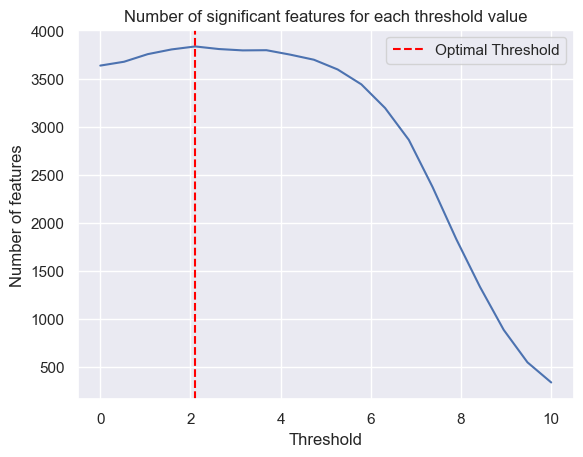

[3635,
 3675,
 3754,
 3803,
 3834,
 3807,
 3793,
 3795,
 3749,
 3696,
 3595,
 3440,
 3194,
 2863,
 2373,
 1831,
 1334,
 887,
 550,
 341]

In [65]:
# Now we plot the number of features we drop for each treshold value with grid search
def grid_search_thresholds(data, thresholds):
    n_features = []
    for threshold in thresholds:
        data_filtered = filter_CPM(data, threshold)
        data_filtered = data_filtered.T
        print("Number of features dropped for CPM", threshold, ":", data.shape[0]-data_filtered.shape[1])
        data_filtered = add_target_column(data_filtered, df_metaH_path, 'Condition', 'category_Normo')
        p_vals = wilcoxon_ranksum_test(data_filtered)
        count = [value for value in q_value(p_vals) if value[1] <= 0.05]
        count = [value[0] for value in count]
        # Delete all columns in count that are not in colsdatafilt
        finaldf = data_filtered[count]
        print("Number of features dropped after q-value test for threshold", threshold, ":", data_filtered.shape[1]-len(count))
        n_features.append(finaldf.shape[1])
        # Plot the number of features we drop for each treshold value
    plt.plot(thresholds, n_features)
    plt.xlabel('Threshold')
    plt.ylabel('Number of features')
    plt.title('Number of significant features for each threshold value')
    plt.axvline(x=2.1, color = "red", linestyle = "--", label = "Optimal Threshold")
    plt.legend()
    plt.show()  
    return n_features

thresholds = np.linspace(start = 0, stop = 10, num = 20)
grid_search_thresholds(mergedT_cpm_log, thresholds)

It's clear that an optimal value for the threshold is approximately 2.1., and by choosing such a value we will keep approximately 3800 features

In [66]:
merged_cpm_log_filtered = filter_CPM(mergedT_cpm_log, 2.1)
merged_cpm_log_filtered = merged_cpm_log_filtered.T
merged_cpm_log_filtered = add_target_column(merged_cpm_log_filtered, df_metaH_path, 'Condition', 'category_Normo')
pvals = wilcoxon_ranksum_test(merged_cpm_log_filtered)
qvals = q_value(pvals)
count = [value for value in qvals if value[1] <= 0.05]
count = [value[0] for value in count]
merged_cpm_log_filtered = merged_cpm_log_filtered[count]

In [67]:
print(merged_cpm_log_filtered.shape)

(243, 3834)


In [68]:
merged_cpm_log_filtered.head()
# Check if there is target in columns with boolean
print('Target' in merged_cpm_log_filtered.columns)

True


In [ ]:
Now we can finally take the Highly Variable Genes, but in order to do so, we need to do FINIREEEEEE

In [69]:
# Now scatter plot the variance of the genes
filt_first = filter_CPM(mergedT_cpm_log, 2.1).T
adata = sc.AnnData(filt_first)

sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=False, flavor='seurat_v3')
# Note since our dataset is already log-transformed as the function 'Expects logarithmized data'
sc.pl.highly_variable_genes(adata, inplace = False)

/Users/edoardoghirardo/miniconda/envs/edo/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


TypeError: highly_variable_genes() got an unexpected keyword argument 'inplace'

In [70]:
adata = adata[:, adata.var['highly_variable']]
print("Total matching: ", adata.var['highly_variable'].index.isin(df_seq_HFiltNorm.index).astype(bool).sum())
print("Percentage matching to the given training dataset: ", round(adata.var['highly_variable'].index.isin(df_seq_HFiltNorm.index).astype(bool).sum()/3000*100, 2), "%")

KeyError: 'highly_variable'

## PCA

In [14]:
# Now use the dataset already Filtered and Normalized to train the model
df_seq_HFiltNorm.T.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,0,48,0,321,298,82,6250,634,0,0,...,78,10,136,0,0,29,0,29,0,0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,8739,2101,55,96,1824,1938,62,0,522,413,...,279,0,264,0,134,68,0,213,0,0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,13098,14032,0,0,1616,247,430,907,348,0,...,311,0,38,0,0,0,0,92,0,0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,2880,356,0,6211,3,3430,79,1953,592,176,...,125,0,16,0,4,1,0,1,0,0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,7777,5661,4383,0,145,4618,246,85,206,0,...,268,1,25,0,0,0,0,128,0,0


In [15]:
# we notice that the data does not have mean 0 and variance 1, so we need to normalize it
df_pca = pd.DataFrame(StandardScaler().fit_transform(df_seq_HFiltNorm.T), columns=df_seq_HFiltNorm.T.columns, index=df_seq_HFiltNorm.T.index)
df_pca.describe()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
count,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,...,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,1.820000e+02,1.820000e+02
mean,-5.124106e-17,-3.904081e-17,9.760202e-18,1.952040e-17,1.708035e-17,9.760202e-18,-4.880101e-18,-1.098023e-17,3.904081e-17,1.952040e-17,...,5.856121e-17,-3.416071e-17,1.073622e-16,-2.928061e-17,4.880101e-18,-5.612116e-17,0.000000,9.760202e-18,2.806058e-17,4.178587e-17
std,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,...,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759e+00,1.002759,1.002759e+00,1.002759e+00,1.002759e+00
min,-9.723033e-01,-6.312357e-01,-4.501474e-01,-3.870188e-01,-6.855151e-01,-4.536436e-01,-5.466842e-01,-4.675648e-01,-7.321758e-01,-2.580442e-01,...,-1.036417e+00,-3.649465e-01,-9.465342e-01,-3.298526e-01,-4.586692e-01,-6.617722e-01,-0.145424,-7.195161e-01,-4.327557e-01,-2.492207e-01
25%,-9.012837e-01,-6.290495e-01,-4.501474e-01,-3.812427e-01,-6.370911e-01,-4.240259e-01,-4.922245e-01,-3.828133e-01,-7.257798e-01,-2.580442e-01,...,-8.052660e-01,-3.649465e-01,-6.994518e-01,-3.298526e-01,-4.586692e-01,-6.588747e-01,-0.145424,-5.486721e-01,-4.327557e-01,-2.492207e-01
50%,-3.151913e-01,-4.820639e-01,-4.501474e-01,-2.523846e-01,-4.487320e-01,-3.571184e-01,-3.587447e-01,-2.683243e-01,-5.027191e-01,-2.580442e-01,...,-2.084750e-01,-3.649465e-01,-2.853759e-01,-3.298526e-01,-1.673264e-01,-2.677146e-01,-0.145424,-3.208801e-01,-4.327557e-01,-2.492207e-01
75%,6.968983e-01,3.243638e-01,7.639423e-02,4.523890e-02,9.598775e-02,-3.846029e-02,2.490059e-02,1.201825e-02,3.691366e-01,-2.580442e-01,...,5.249054e-01,-3.649465e-01,3.553342e-01,-5.468145e-02,1.422253e-01,1.263430e-01,-0.145424,1.097892e-01,-2.603919e-02,-2.492207e-01
max,3.048129e+00,6.586620e+00,5.747386e+00,1.166075e+01,4.780656e+00,7.237685e+00,7.295133e+00,1.087212e+01,4.634074e+00,6.183996e+00,...,5.276118e+00,5.418124e+00,4.860753e+00,1.095217e+01,1.204479e+01,6.466034e+00,10.252367,6.149837e+00,7.418642e+00,7.425015e+00


In [16]:
df_pca.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-0.972303,-0.606545,-0.450147,-0.252175,-0.449918,-0.424383,1.880221,-0.296169,-0.732176,-0.258044,...,-0.380788,0.485505,-0.019549,-0.329853,-0.458669,-0.325664,-0.145424,-0.520198,-0.432756,-0.249221
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,1.131562,0.449488,-0.387969,-0.346692,0.756530,0.237912,-0.522609,-0.467565,0.102503,0.010645,...,1.308719,-0.364947,0.852907,-0.329853,0.625773,0.126343,-0.145424,0.789606,-0.432756,-0.249221
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,2.180967,6.586620,-0.450147,-0.387019,0.592086,-0.365504,-0.379713,-0.222367,-0.175723,-0.258044,...,1.577695,-0.364947,-0.687524,-0.329853,-0.458669,-0.661772,-0.145424,-0.071733,-0.432756,-0.249221
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,-0.278959,-0.448114,-0.450147,2.222070,-0.683143,0.770317,-0.516008,0.060409,0.214433,-0.143542,...,0.014271,-0.364947,-0.837477,-0.329853,-0.426298,-0.650182,-0.145424,-0.719516,-0.432756,-0.249221
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,0.899966,2.280700,4.504940,-0.387019,-0.570879,1.194243,-0.451161,-0.444586,-0.402781,-0.258044,...,1.216258,-0.279901,-0.776133,-0.329853,-0.458669,-0.661772,-0.145424,0.184533,-0.432756,-0.249221


In [17]:
merged_df_pca = pd.merge(df_pca, df_metaH['Condition'], left_index=True, right_index=True)
merged_df_pca

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2,Condition
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-0.972303,-0.606545,-0.450147,-0.252175,-0.449918,-0.424383,1.880221,-0.296169,-0.732176,-0.258044,...,0.485505,-0.019549,-0.329853,-0.458669,-0.325664,-0.145424,-0.520198,-0.432756,-0.249221,Normo
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,1.131562,0.449488,-0.387969,-0.346692,0.756530,0.237912,-0.522609,-0.467565,0.102503,0.010645,...,-0.364947,0.852907,-0.329853,0.625773,0.126343,-0.145424,0.789606,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,2.180967,6.586620,-0.450147,-0.387019,0.592086,-0.365504,-0.379713,-0.222367,-0.175723,-0.258044,...,-0.364947,-0.687524,-0.329853,-0.458669,-0.661772,-0.145424,-0.071733,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,-0.278959,-0.448114,-0.450147,2.222070,-0.683143,0.770317,-0.516008,0.060409,0.214433,-0.143542,...,-0.364947,-0.837477,-0.329853,-0.426298,-0.650182,-0.145424,-0.719516,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,0.899966,2.280700,4.504940,-0.387019,-0.570879,1.194243,-0.451161,-0.444586,-0.402781,-0.258044,...,-0.279901,-0.776133,-0.329853,-0.458669,-0.661772,-0.145424,0.184533,-0.432756,-0.249221,Hypo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,-0.953284,-0.628664,-0.450147,0.494300,-0.247526,-0.418316,-0.236817,0.670837,-0.629840,-0.258044,...,-0.364947,0.852907,-0.329853,-0.377741,-0.267715,-0.145424,-0.555791,-0.432756,-0.249221,Normo
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,-0.932099,-0.630721,-0.450147,-0.375677,2.148767,-0.405827,-0.545519,-0.306442,-0.714587,-0.258044,...,-0.364947,-0.128606,0.816694,-0.458669,-0.047506,-0.145424,0.533340,1.441677,-0.249221,Normo
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,1.479920,0.987535,-0.450147,-0.324428,0.114567,-0.414034,-0.268658,-0.300765,0.457481,-0.258044,...,-0.364947,-0.571651,-0.329853,0.811909,-0.163405,-0.145424,0.077756,-0.432756,-0.249221,Hypo
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,-0.915006,-0.610146,2.791065,-0.045077,1.059327,-0.347662,-0.149448,0.310744,-0.730577,-0.258044,...,-0.364947,-0.660259,-0.329853,-0.248255,-0.661772,-0.145424,-0.634094,-0.255922,-0.249221,Normo


In [18]:
# we start by performing pca with 3 principal components to visualize the data

pca = PCA(n_components=3)
three_dim_array = pca.fit_transform(df_pca)
three_dim_df = pd.DataFrame(three_dim_array, columns=['PC1', 'PC2', 'PC3'], index=df_seq_HFiltNorm.T.index)
three_dim_df.head()


,PC1,PC2,PC3
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-2.848650,-5.627519,3.324482
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,7.899447,10.450219,-8.563059
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,-0.497193,12.702590,-9.188911
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,4.082616,8.092225,-4.658898
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,2.255647,2.846728,-4.773500


In [19]:
# Dataframe to plot
merged_three_dim = pd.merge(three_dim_df, df_metaH['Condition'], left_index=True, right_index=True)
merged_three_dim.head()

,PC1,PC2,PC3,Condition
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,-2.848650,-5.627519,3.324482,Normo
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,7.899447,10.450219,-8.563059,Hypo
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,-0.497193,12.702590,-9.188911,Hypo
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,4.082616,8.092225,-4.658898,Hypo
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,2.255647,2.846728,-4.773500,Hypo


In [22]:
import plotly.express as px

fig = px.scatter_3d(
    data_frame = merged_three_dim,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    title="Projecing the data on the 3 principal components with PCA",
    color = "Condition",
)
# Show the fig
fig.show()

In [26]:
expl_var = sum(pca.explained_variance_ratio_)
print("Explained variance by the first 3 principal components: ", expl_var)
# while clearly not linearly separable, we see that the data has some structure when projected back to 3 dimensions. however, we likely need more dimensions as 3 only explain around 10% of the variance


Explained variance by the first 3 principal components:  0.09589203869142185


The number of dimensions needed to explain 95% of the variance is 156


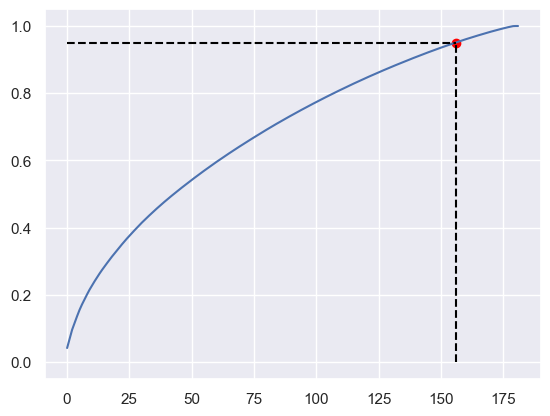

In [41]:
# we perform pca again
pca = PCA()
pca_array = pca.fit_transform(df_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
index_95 = np.argmax(cumsum >= 0.95)
plt.scatter(index_95, 0.95, color='red')
plt.plot([index_95, index_95], [0, 0.95], linestyle='--', color='black')
plt.plot([0, index_95], [0.95, 0.95], linestyle='--', color='black')
print(f"The number of dimensions needed to explain 95% of the variance is {index_95}")